# <font size=+3 color="#adb5bd">Reconocimiento de Estilo de Escritura para <font color="black">**Space**</font><font color="#FF6A13">**News**</font>.com</font>

<font size=+2>Curso:</font>

<font size=+1 color="#adb5bd">Data Science III: NLP & Deep Learning Aplicado a Ciencia de Datos</font>

<font size=+1 color="#adb5bd">Comisión #60960</font>

<font size=+2>Alumno:</font>

<font size=+2 color="#adb5bd">Morales Volosín, Juan Ignacio</font><br>

<font size=+2>Profesor:</font>

<font size=+1 color="#adb5bd">Russo Locati, Ignacio</font>

<font size=+2>Tutor:</font>

<font size=+1 color="#adb5bd">Alric, Juan Cruz</font>

## Instrucciones

Estas son algunas indicaciones que pueden resultar de utilidad al momento de interactuar con este notebook.

**Archivos**

Tanto el presente notebook, como conjunto de datos, como los `DataFrames` guardados y los modelos de aprendizaje automático o profundo se encuentran en [esta carpeta](https://drive.google.com/drive/folders/1oIscaXo9_KrQvFbnJqxHQlm9jOG1cpOv?usp=drive_link).

**Tabla de Contenidos**

Aunque pueda parecer una aclaración redundante, el presente notebook se pensó para quedar ordenado mediante los encabezados que figuran en dicha tabla.

**Puntos de Control**

Se pueden ubicar mediante la tabla de contenidos y permiten guardar o cargar `DataFrames` o modelos entrenados, sin necesidad de ejecutar todo el código que precede al punto de control. Para ello, los archivos necesarios deben estar en el directorio raíz de `Google Drive`.

A pesar de ello, puede resultar necesario ejecutar algunas partes, como por ejemplo los encabezados:
- Recursos
- Preparación

Por otro lado, se debe tener en cuenta que el notebook corre conectándose al raíz de `Google Drive` y que algunas de sus celdas piden responder pretuntas de sí/no.

## Objetivo

El objetivo de este proyecto es desarrollar una solución analítica para SpaceNews.com que permita detectar plagios a su contenido, identificando textos externos que puedan haber sido copiados de su sitio web. A través de un proceso de preprocesamiento en lenguaje natural (NLP), se buscará comprender la temática de los artículos y analizar el estilo de escritura de los autores más prolíficos. Utilizando lematización, stemming y técnicas de clasificación con modelos de machine learning y redes neuronales, se pretende predecir la autoría de un artículo en función del estilo de escritura y así determinar que la fuente del texto externo es en realidad un escritor de SpaceNews.com.

### Contexto de Negocio

SpaceNews.com es una plataforma líder en la cobertura de noticias sobre el sector espacial. Con el aumento del contenido digital, la protección de la propiedad intelectual se ha vuelto crucial para mantener la integridad de su información. Ante el riesgo de plagio, la necesidad de implementar una solución que identifique y mitigue estos problemas es de vital importancia para preservar la propiedad de su contenido.

### Contexto Analítico

Este análisis comenzará con un preprocesamiento exhaustivo de los textos, que incluirá normalización, eliminación de stopwords, lematización y stemming, para obtener representaciones manejables de los artículos. Se explorará la temática de los contenidos utilizando una bolsa de palabras, identificando términos clave. Posteriormente, se aplicará TF-IDF para analizar el estilo de escritura de los diez autores que más artículos han contribuido, generando perfiles de autoría. Las preguntas que guiarán este estudio incluirán: ¿Cuántos años lleva publicando SpaceNews.com? ¿Cuántos autores han colaborado a lo largo de su existencia? ¿Quiénes son los diez autores más prolíficos y cuál es la longitud típica de los artículos del sitio?

## Recursos

### Fuente

Este conjunto de datos contiene el título, la URL, el contenido textual, el autor y la fecha de publicación de más de 20,000 artículos de noticias en inglés relacionados con la industria espacial, acumulando más de 14 millones de tokens (palabras). Es ideal para entrenar modelos de lenguaje específicos del ecosistema espacial, abarcando noticias de agencias, comerciales, civiles, lanzamientos, militares y también artículos de opinión.

Puede encontrárselo [aquí](https://www.kaggle.com/datasets/patrickfleith/space-news-dataset).

<font size=+1>Diccionario de Variables del Dataset</font>

| Variable      | Tipo de Dato | Descripción                                        |
|---------------|--------------|----------------------------------------------------|
| title         | String       | Título del artículo publicado en SpaceNews.com.   |
| url           | String       | URL del artículo en SpaceNews.com.                 |
| content       | Text         | Contenido completo del artículo.                   |
| author        | String       | Nombre del autor que escribió el artículo.        |
| date          | Date         | Fecha de publicación del artículo.                 |
| postexcerpt   | String       | Extracto o resumen breve del artículo.             |

### Bibliotecas

In [ ]:
import os
import joblib
import pickle
from google.colab import drive

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim

### Configuraciones

In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Limit removal for showing pandas.DataFrames' columns
pd.set_option('display.max_columns', None)
# Limit removal for showing pandas.DataFrames' rows
pd.set_option('display.max_rows', None)
# Modification of console with for displaying
pd.set_option('display.width', 800)

### Funciones Personalizadas

In [ ]:
def analiza_df(df):
    cant_filas = df.shape[0]
    cant_colms = df.shape[1]
    s_cant_nulos = df.isnull().sum()
    total_nulos = df.isnull().sum().sum()
    # Prepara un DataFrame de reporte
    df_verif = pd.DataFrame(
        {
            'tp_dato': [df[col].dtype.name for col in df.columns],
            '#_unico': [df[col].nunique() for col in df.columns],
            '#_!nulo': cant_filas - s_cant_nulos,
            '#_nulos': s_cant_nulos,
            '%_nulos': 100 * df.isnull().mean().round(4)
        }
    )

    print(df_verif, '\n')
    print('Además:\n')
    print(f'El total de nulos es: {total_nulos}\n')
    print(f'Y el DataFrame tiene {cant_filas} filas y {cant_colms} columnas.')

### Descargas

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Carga de Datos y Exploración

In [ ]:
#df_sn = pd.read_csv('spacenews.csv')
ruta = '/content/drive/My Drive/006 - Estudio/Coderhouse/Data Science 3/Proyecto/spacenews.csv'
df_sn = pd.read_csv(ruta)
# Encabezado
print(df_sn.head(10))

                                               title                                                url                                            content         author          date postexcerpt
0  Electron launches first NASA PREFIRE Earth sci...  https://spacenews.com/electron-launches-first-...  LOS ANGELES — Rocket Lab launched the first of...     Jeff Foust  May 25, 2024         NaN
1  Space Development Agency to procure dedicated ...  https://spacenews.com/space-development-agency...  WASHINGTON —  T he Space Development Agency (S...   Sandra Erwin  May 25, 2024         NaN
2  Bringing generative artificial intelligence to...  https://spacenews.com/bringing-generative-arti...  TAMPA, Fla. — Amazon Web Services is busy posi...  Jason Rainbow  May 24, 2024         NaN
3  SpaceX sets early June launch of next Starship...  https://spacenews.com/spacex-sets-early-june-l...  LOS ANGELES — SpaceX has set a June 5 launch d...     Jeff Foust  May 24, 2024         NaN
4  NASA and Boeing m

Pie.

In [ ]:
print(df_sn.tail(10))

                                                   title                                                url                                            content              author                date                                        postexcerpt
20706  Satellite builders unsure what Trump will mean...  https://spacenews.com/satellite-builders-unsur...  WASHINGTON — Satellite manufacturers aren’t ye...         Caleb Henry       March 8, 2017  Satellite manufacturers aren’t yet sure how th...
20707  Military, industry hope 2017 means big improve...  https://spacenews.com/military-industry-hope-2...    WASHINGTON — Acquisition reform must begin w...      Phillip Swarts       March 7, 2017  Acquisition reform must begin with closer coop...
20708  Poland, China to jointly build satellites, boo...  https://spacenews.com/poland-china-to-jointly-...  WARSAW — Poland’s deputy prime minister and sc...  Jarosław Adamowski    November 3, 2016   Poland’s deputy prime minister and science mi...


Filas y columnas.

In [ ]:
df_sn.shape

(20716, 6)

Simplificación de nombre de columna

In [ ]:
df_sn = df_sn.rename(columns = {'postexcerpt': 'excerpt'})

Descripción estadística

In [ ]:
print(df_sn.describe(include = 'all').T)

         count unique                                                top  freq
title    20716  20716  Electron launches first NASA PREFIRE Earth sci...     1
url      20716  20715  https://spacenews.com/launcher-wins-space-forc...     2
content  20551  20543                                                        3
author   20716    649                                         Jeff Foust  5293
date     20716   4367                                    October 1, 2011   178
excerpt  18196  18175  FIRST UP Satcom is a weekly SpaceNews newslett...     3


Verificación de existencia de duplicados.

In [ ]:
df_sn.duplicated().any()

False

Análisis personalizado: tipos de dato, únicos, nulos.

In [ ]:
analiza_df(df_sn)

        tp_dato  #_unico  #_!nulo  #_nulos  %_nulos
title    object    20716    20716        0     0.00
url      object    20715    20716        0     0.00
content  object    20543    20551      165     0.80
author   object      649    20716        0     0.00
date     object     4367    20716        0     0.00
excerpt  object    18175    18196     2520    12.16 

Además:

El total de nulos es: 2685

Y el DataFrame tiene 20716 filas y 6 columnas.


Que `'content'` presente nulos no resulta aceptable, ya que es la variable de mayor interés.

In [ ]:
print(df_sn[df_sn['content'].isnull()].head(10))

                                                  title                                                url content            author               date                                            excerpt
4322  SpaceFund to invest in navigation system for c...  https://spacenews.com/spacefund-to-invest-in-n...     NaN      Sandra Erwin   November 3, 2021  Venture investor SpaceFund announced Nov. 3 it...
7025                       Coronavirus special coverage  https://spacenews.com/coronavirus-special-cove...     NaN   SpaceNews Staff     March 19, 2020  SpaceNews special  coverage of the novel coron...
7052               Space in the time of the coronavirus  https://spacenews.com/space-in-the-time-of-the...     NaN        Jeff Foust     March 13, 2020  Satellite 2020 was forced to end early but at ...
7569  Ursa raises $15 million in Series B funding round  https://spacenews.com/ursa-raises-15-million-i...     NaN      Debra Werner   November 7, 2019  Ursa Space Systems, a geospatial an

En los casos en que `'content'` es nulo, ¿`'postexcerpt'` lo es también?

In [ ]:
df_sn[(df_sn['content'].isnull()) & (df_sn['excerpt'].isnull())].shape

(1, 6)

Sólo un caso. Se eliminará este registro.

In [ ]:
df_sn = df_sn[~((df_sn['content'].isnull()) & (df_sn['excerpt'].isnull()))].reset_index(drop = True)
df_sn.shape

(20715, 6)

Se remplazan los nulos restantes de `'content'` con los textos de `'excerpt'`, buscando salvar la mayor cantidad de datos posibles.

In [ ]:
df_sn.loc[:, 'content'] = df_sn['content'].where(
    ~df_sn['content'].isnull(),
    df_sn['excerpt']
)

Finalmente, se elimina la columna `'excerpt'` ya que el contenido a analizar se halla realmente en `'content'`.

In [ ]:
df_sn = df_sn.drop(columns = 'excerpt')

Conversión de tipo para `'date'`.

In [ ]:
df_sn['date'] = pd.to_datetime(df_sn['date'])

Análisis del `DataFrame` tras las transformaciones iniciales.

In [ ]:
analiza_df(df_sn)

                tp_dato  #_unico  #_!nulo  #_nulos  %_nulos
title            object    20715    20715        0      0.0
url              object    20714    20715        0      0.0
content          object    20707    20715        0      0.0
author           object      649    20715        0      0.0
date     datetime64[ns]     4367    20715        0      0.0 

Además:

El total de nulos es: 0

Y el DataFrame tiene 20715 filas y 5 columnas.


### Punto de Control

Guardado del `DataFrame` previo a tareas de preprocesamiento para NLP.

In [ ]:
# Ruta del archivo
folder_df_initial = '/content/drive/My Drive/'
name_df_initial = 'df_sn_initial.feather'

In [ ]:
# Guardado, sobreescritura según existencia de archivo
if os.path.exists(folder_df_initial + name_df_initial):
    inp_aswr = input(f'Archivo "{name_df_initial}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió.')
    else:
        df_sn.to_feather(folder_df_initial + name_df_initial)
        print('Se sobreescribió.')
else:
    df_sn.to_feather(folder_df_initial + name_df_initial)
    print('Archivo guardado.')

Archivo "df_sn_initial.feather" ya existente. ¿Sobrescribirlo? (s/n): n
No se sobreescribió.


### Exploración Visual

Cantidad de publicaciones por año.

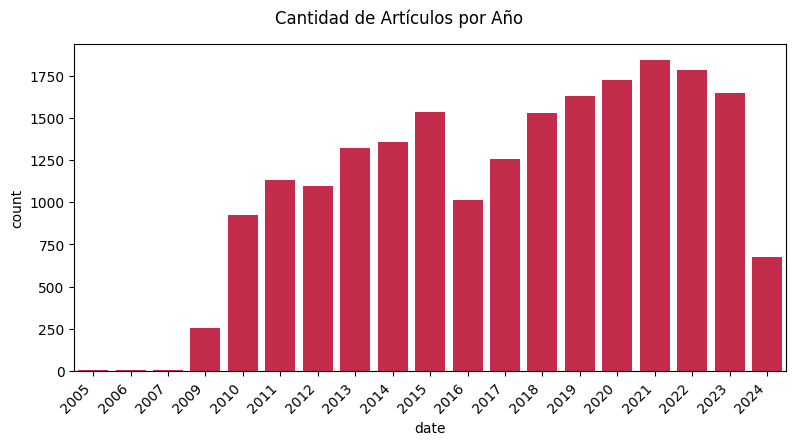

In [ ]:
year_hist = sns.catplot(
    data = df_sn,
    x = df_sn['date'].dt.year,
    kind = 'count',
    height = 4,
    aspect = 2,
    color = 'crimson'
)

year_hist.fig.suptitle('Cantidad de Artículos por Año', y = 1.05)
year_hist.set_xticklabels(rotation = 45, ha = 'right')
year_hist.axes[0, 0].spines['top'].set_visible(True)
year_hist.axes[0, 0].spines['right'].set_visible(True)
plt.show()

Tener presente que el conjunto de datos incluye registros de una parte de 2024, ya que se confeccionó previo a finalizado el año.

Cantidad de autores.

In [ ]:
df_sn['author'].nunique()

649

Autores con la mayor cantidad de artículos.

In [ ]:
df_sn_top10writers = df_sn.groupby('author')['date'].count().nlargest(10)
df_sn_top10writers = df_sn_top10writers.to_frame().reset_index().rename(columns = {'date': 'article_count'})
print(df_sn_top10writers)

                author  article_count
0           Jeff Foust           5293
1         Sandra Erwin           2743
2  Peter B. de Selding           2539
3         Debra Werner           1589
4          Caleb Henry           1172
5      SpaceNews Staff            888
6        Jason Rainbow            880
7            Dan Leone            795
8           Mike Gruss            789
9         Andrew Jones            595


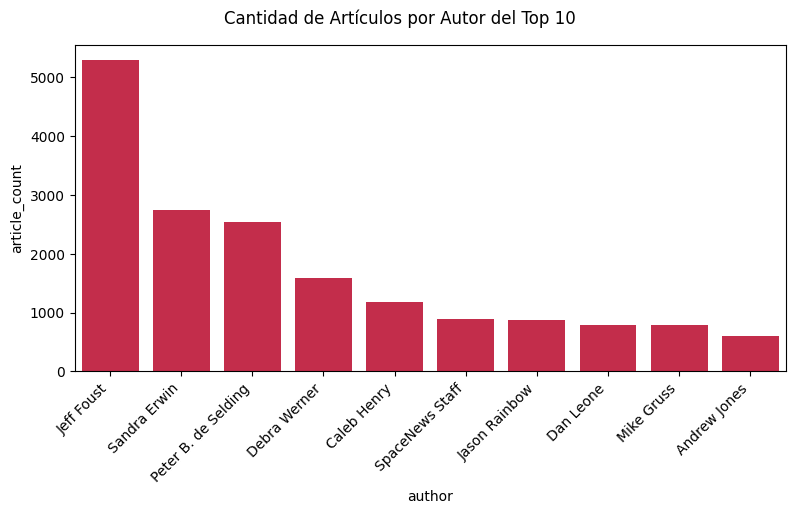

In [ ]:
t10wr = sns.catplot(
    data = df_sn_top10writers,
    x = 'author',
    y = 'article_count',
    kind = 'bar',
    height = 4,
    aspect = 2,
    color = 'crimson'
)
t10wr.set_xticklabels(rotation = 45, ha = 'right')
t10wr.fig.suptitle('Cantidad de Artículos por Autor del Top 10', y = 1.05)
t10wr.axes[0, 0].spines['top'].set_visible(True)
t10wr.axes[0, 0].spines['right'].set_visible(True)
plt.show()

In [ ]:
# Nombre del archivo
name_df_top10writers = 'df_sn_top10writers.feather'

In [ ]:
# Guardado, sobreescritura según existencia de archivo
if os.path.exists(folder_df_initial + name_df_top10writers):
    inp_aswr = input(f'Archivo "{name_df_top10writers}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió.')
    else:
        df_sn_top10writers.to_feather(folder_df_initial + name_df_top10writers)
        print('Se sobreescribió.')
else:
    df_sn_top10writers.to_feather(folder_df_initial + name_df_top10writers)
    print('Archivo creado y guardado.')

Archivo "df_sn_top10writers.feather" ya existente. ¿Sobrescribirlo? (s/n): n
No se sobreescribió.


Variable con longitud de contenido.

In [ ]:
df_sn['content_len'] = df_sn['content'].apply(lambda x: len(x) if pd.notna(x) else 0)
print(df_sn.head(10))

                                               title                                                url                                            content         author       date  content_len
0  Electron launches first NASA PREFIRE Earth sci...  https://spacenews.com/electron-launches-first-...  LOS ANGELES — Rocket Lab launched the first of...     Jeff Foust 2024-05-25         3218
1  Space Development Agency to procure dedicated ...  https://spacenews.com/space-development-agency...  WASHINGTON —  T he Space Development Agency (S...   Sandra Erwin 2024-05-25         2730
2  Bringing generative artificial intelligence to...  https://spacenews.com/bringing-generative-arti...  TAMPA, Fla. — Amazon Web Services is busy posi...  Jason Rainbow 2024-05-24         3232
3  SpaceX sets early June launch of next Starship...  https://spacenews.com/spacex-sets-early-june-l...  LOS ANGELES — SpaceX has set a June 5 launch d...     Jeff Foust 2024-05-24         4515
4  NASA and Boeing moving ahea

In [ ]:
print(df_sn[['content_len']].describe().T)

               count         mean         std  min     25%     50%     75%      max
content_len  20715.0  3896.798503  2237.49039  1.0  2481.0  3659.0  4843.0  80006.0


¿Qué longitud tiene el contenido?

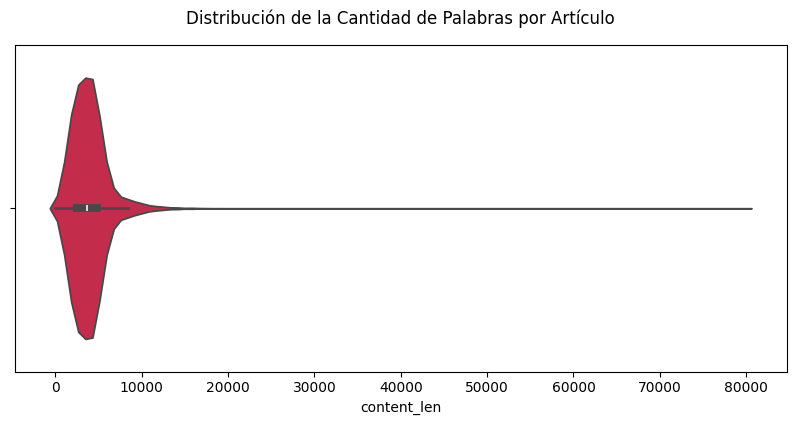

In [ ]:
con_len_vio = sns.catplot(
    data = df_sn,
    x = 'content_len',
    kind = 'violin',
    height = 4,
    aspect = 2,
    color = 'crimson'
)

con_len_vio.fig.suptitle('Distribución de la Cantidad de Palabras por Artículo', y = 1.05)
con_len_vio.axes[0, 0].spines['top'].set_visible(True)
con_len_vio.axes[0, 0].spines['right'].set_visible(True)
plt.show()

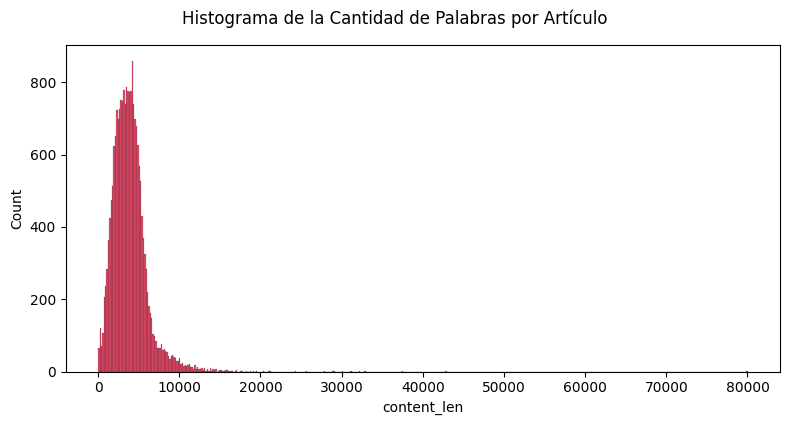

In [ ]:
con_len_his = sns.displot(
    data = df_sn,
    x = 'content_len',
    kind = 'hist',
    height = 4,
    aspect = 2,
    color = 'crimson'
)

con_len_his.fig.suptitle('Histograma de la Cantidad de Palabras por Artículo', y = 1.05)
con_len_his.axes[0, 0].spines['top'].set_visible(True)
con_len_his.axes[0, 0].spines['right'].set_visible(True)
plt.show()

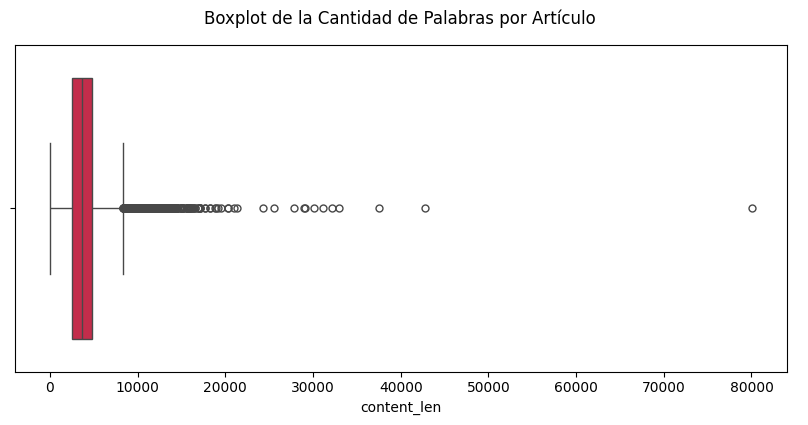

In [ ]:
con_len_box = sns.catplot(
    data = df_sn,
    x = 'content_len',
    kind = 'box',
    height = 4,
    aspect = 2,
    color = 'crimson'
)

con_len_box.fig.suptitle('Boxplot de la Cantidad de Palabras por Artículo', y = 1.05)
con_len_box.axes[0, 0].spines['top'].set_visible(True)
con_len_box.axes[0, 0].spines['right'].set_visible(True)
plt.show()

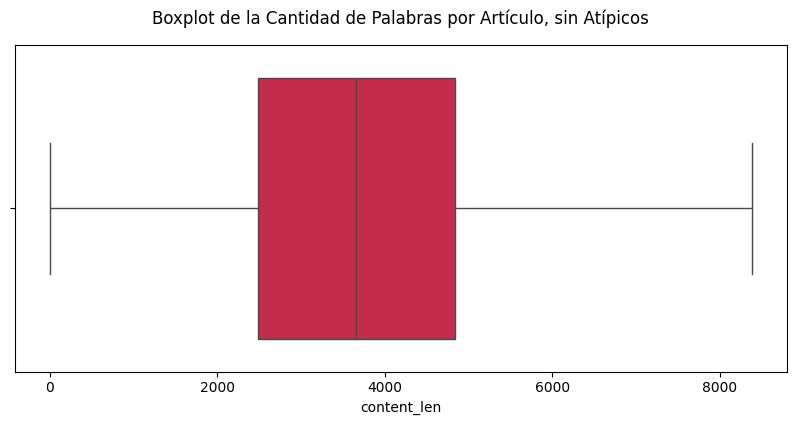

In [ ]:
con_len_bxo = sns.catplot(
    data = df_sn,
    x = 'content_len',
    kind = 'box',
    height = 4,
    aspect = 2,
    color = 'crimson',
    showfliers = False
)

con_len_bxo.fig.suptitle('Boxplot de la Cantidad de Palabras por Artículo, sin Atípicos', y = 1.05)
con_len_bxo.axes[0, 0].spines['top'].set_visible(True)
con_len_bxo.axes[0, 0].spines['right'].set_visible(True)
plt.show()

## Preprocesamiento para NLP

### Estandarización

Eliminación de mayúsculas y caracteres especiales.

In [ ]:
%%time
# Texto a minúsculas
df_sn['content'] = df_sn['content'].str.lower()

# Eliminación caracteres especiales y números
df_sn['content'] = df_sn['content'].str.replace(r'[^a-záéíóúñü\s]', '', regex = True)

# Muestra poslimpieza
print(df_sn['content'].head())
print()

0    los angeles  rocket lab launched the first of ...
1    washington   t he space development agency sda...
2    tampa fla  amazon web services is busy positio...
3    los angeles  spacex has set a june  launch dat...
4    los angeles  nasa and boeing are preparing for...
Name: content, dtype: object

CPU times: user 3.03 s, sys: 404 ms, total: 3.43 s
Wall time: 3.91 s


### Tokenización

In [ ]:
%%time
# Tokenización
df_sn['content_tkn'] = df_sn['content'].apply(word_tokenize)

# Textos tokenizados, encabezado
print(df_sn[['content', 'content_tkn']].head(10))
print()

                                             content                                        content_tkn
0  los angeles  rocket lab launched the first of ...  [los, angeles, rocket, lab, launched, the, fir...
1  washington   t he space development agency sda...  [washington, t, he, space, development, agency...
2  tampa fla  amazon web services is busy positio...  [tampa, fla, amazon, web, services, is, busy, ...
3  los angeles  spacex has set a june  launch dat...  [los, angeles, spacex, has, set, a, june, laun...
4  los angeles  nasa and boeing are preparing for...  [los, angeles, nasa, and, boeing, are, prepari...
5  washington  european officials adopted a resol...  [washington, european, officials, adopted, a, ...
6  washington  nasa administrator bill nelson def...  [washington, nasa, administrator, bill, nelson...
7  washington  the us space force is soliciting b...  [washington, the, us, space, force, is, solici...
8  tampa fla  intelsat has signed a deal to use t...  [tampa, fl

In [ ]:
# Textos tokenizados, pie
print(df_sn[['content', 'content_tkn']].tail(10))

                                                 content                                        content_tkn
20705  washington  satellite manufacturers arent yet ...  [washington, satellite, manufacturers, arent, ...
20706    washington  acquisition reform must begin wi...  [washington, acquisition, reform, must, begin,...
20707  warsaw  polands deputy prime minister and scie...  [warsaw, polands, deputy, prime, minister, and...
20708  national security experts told a house oversig...  [national, security, experts, told, a, house, ...
20709  washington  members of congress and former nas...  [washington, members, of, congress, and, forme...
20710  \nfrank kendall the pentagons top acquisition ...  [frank, kendall, the, pentagons, top, acquisit...
20711  updated feb  at  pm eastern the us national oc...  [updated, feb, at, pm, eastern, the, us, natio...
20712  washington  as nasa develops a longterm strate...  [washington, as, nasa, develops, a, longterm, ...
20713  washington  a spendin

### Stopwords

In [ ]:
%%time
# Stopwords
stop_words = set(stopwords.words('english'))

# Eliminación de stopwords
df_sn['content_tkn_stw'] = df_sn['content_tkn'].apply(lambda x: [word for word in x if word not in stop_words])

# Tokens sin stopwords, encabezado
print(df_sn[['content_tkn', 'content_tkn_stw']].head())
print()

                                         content_tkn                                    content_tkn_stw
0  [los, angeles, rocket, lab, launched, the, fir...  [los, angeles, rocket, lab, launched, first, t...
1  [washington, t, he, space, development, agency...  [washington, space, development, agency, sda, ...
2  [tampa, fla, amazon, web, services, is, busy, ...  [tampa, fla, amazon, web, services, busy, posi...
3  [los, angeles, spacex, has, set, a, june, laun...  [los, angeles, spacex, set, june, launch, date...
4  [los, angeles, nasa, and, boeing, are, prepari...  [los, angeles, nasa, boeing, preparing, june, ...

CPU times: user 1.64 s, sys: 19.9 ms, total: 1.66 s
Wall time: 1.66 s


In [ ]:
# Tokens sin stopwords, pie
print(df_sn[['content_tkn', 'content_tkn_stw']].tail())

                                             content_tkn                                    content_tkn_stw
20710  [frank, kendall, the, pentagons, top, acquisit...  [frank, kendall, pentagons, top, acquisition, ...
20711  [updated, feb, at, pm, eastern, the, us, natio...  [updated, feb, pm, eastern, us, national, ocea...
20712  [washington, as, nasa, develops, a, longterm, ...  [washington, nasa, develops, longterm, strateg...
20713  [washington, a, spending, bill, the, house, pa...  [washington, spending, bill, house, passed, ju...
20714  [us, rep, jim, bridenstine, rokla, is, a, grow...  [us, rep, jim, bridenstine, rokla, growing, pr...


### Lematización

In [ ]:
# Objeto lematizador
lemmatizer = WordNetLemmatizer()

In [ ]:
# Función de lematización
def lemmatize_text(text):
    tokens = word_tokenize(' '.join(text))
    return [lemmatizer.lemmatize(token) for token in tokens]

In [ ]:
%%time

# Lematización
df_sn['content_tkn_stw_lma'] = df_sn['content_tkn_stw'].apply(lemmatize_text)

# Lemas de tokens sin stopwords, encabezado
print(df_sn[['content_tkn_stw', 'content_tkn_stw_lma']].head())
print()

                                     content_tkn_stw                                content_tkn_stw_lma
0  [los, angeles, rocket, lab, launched, first, t...  [los, angeles, rocket, lab, launched, first, t...
1  [washington, space, development, agency, sda, ...  [washington, space, development, agency, sda, ...
2  [tampa, fla, amazon, web, services, busy, posi...  [tampa, fla, amazon, web, service, busy, posit...
3  [los, angeles, spacex, set, june, launch, date...  [los, angeles, spacex, set, june, launch, date...
4  [los, angeles, nasa, boeing, preparing, june, ...  [los, angeles, nasa, boeing, preparing, june, ...

CPU times: user 1min 17s, sys: 888 ms, total: 1min 18s
Wall time: 1min 22s


In [ ]:
# Lemas de tokens sin stopwords, pie
print(df_sn[['content_tkn_stw', 'content_tkn_stw_lma']].tail())

                                         content_tkn_stw                                content_tkn_stw_lma
20710  [frank, kendall, pentagons, top, acquisition, ...  [frank, kendall, pentagon, top, acquisition, o...
20711  [updated, feb, pm, eastern, us, national, ocea...  [updated, feb, pm, eastern, u, national, ocean...
20712  [washington, nasa, develops, longterm, strateg...  [washington, nasa, develops, longterm, strateg...
20713  [washington, spending, bill, house, passed, ju...  [washington, spending, bill, house, passed, ju...
20714  [us, rep, jim, bridenstine, rokla, growing, pr...  [u, rep, jim, bridenstine, rokla, growing, pre...


### Stemming y Punto de Control

In [ ]:
%%time

# Ruta del archivo para el stemming
name_df_stem = 'df_sn_stem.feather'

# Distintas acciones para el stemming
if os.path.exists(folder_df_initial + name_df_stem):
    inp_aswr_stm = input(f'Archivo "{name_df_stem}" ya existente. ¿Aplicar stemming nuevamente? (s/n): ')
    if inp_aswr_stm.lower() == 's':
        # SnowballStemmer stemmer, de nltk
        stemmer = SnowballStemmer('english')

        # Aplicación de stemming
        df_sn['content_tkn_stw_stm'] = df_sn['content_tkn_stw'].apply(lambda x: [stemmer.stem(word) for word in x])

        # Guardado de DataFrame
        df_sn.to_feather(folder_df_initial + name_df_stem)
        print('Archivo de DataFrame sobreescrito.')
        print()

        # Stemming sobre lemas de tokens sin stopwords, encabezado
        print(df_sn[['content_tkn_stw', 'content_tkn_stw_stm']].head())
        print()
    else:
        df_sn = pd.read_feather(folder_df_initial + name_df_stem)
        print('Archivo de DataFrame leído.')
        print()
else:
    # SnowballStemmer stemmer, de nltk
    stemmer = SnowballStemmer('english')

    # Aplicación de stemming
    df_sn['content_tkn_stw_stm'] = df_sn['content_tkn_stw'].apply(lambda x: [stemmer.stem(word) for word in x])

    # Guardado de DataFrame
    df_sn.to_feather(folder_df_initial + name_df_stem)
    print('Archivo de DataFrame creado.')
    print()

    # Stemming sobre lemas de tokens sin stopwords, encabezado
    print(df_sn[['content_tkn_stw', 'content_tkn_stw_stm']].head())
    print()

Archivo "df_sn_stem.feather" ya existente. ¿Aplicar stemming nuevamente? (s/n): n
Archivo de DataFrame leído.

CPU times: user 2.61 s, sys: 2.16 s, total: 4.77 s
Wall time: 22.9 s


In [ ]:
# Stemming sobre lemas de tokens sin stopwords, pie
print(df_sn[['content_tkn_stw', 'content_tkn_stw_stm']].tail())

                                         content_tkn_stw                                content_tkn_stw_stm
20710  [frank, kendall, pentagons, top, acquisition, ...  [frank, kendal, pentagon, top, acquisit, offic...
20711  [updated, feb, pm, eastern, us, national, ocea...  [updat, feb, pm, eastern, us, nation, ocean, a...
20712  [washington, nasa, develops, longterm, strateg...  [washington, nasa, develop, longterm, strategi...
20713  [washington, spending, bill, house, passed, ju...  [washington, spend, bill, hous, pass, june, wo...
20714  [us, rep, jim, bridenstine, rokla, growing, pr...  [us, rep, jim, bridenstin, rokla, grow, presen...


In [ ]:
'''
### CARGA DESDE PUNTO DE CONTROL
df_sn = pd.read_feather(folder_df_initial + name_df_stem)
print('Archivo de DataFrame cargado.')
print(df_sn.head())
'''

### Comparación Antes/Después de Preprocesamiento

In [ ]:
# Longitud de tento proprocesado
# Lematizado
df_sn['content_lma_len'] = df_sn['content_tkn_stw_lma'].apply(len)
# Radicado
df_sn['content_stm_len'] = df_sn['content_tkn_stw_stm'].apply(len)

In [ ]:
print(df_sn[['content_len', 'content_lma_len', 'content_stm_len']].describe(include = 'all').T)

                   count         mean          std  min     25%     50%     75%      max
content_len      20715.0  3896.798503  2237.490390  1.0  2481.0  3659.0  4843.0  80006.0
content_lma_len  20715.0   362.929278   204.298927  0.0   234.0   342.0   450.0   7363.0
content_stm_len  20715.0   362.929278   204.298927  0.0   234.0   342.0   450.0   7363.0


Se puede apreciar una reducción de un orden de magnitud en la cantidad de palabras (o lemas/raíces) tras el preprocesamiento.

## Tareas de NLP

### Bag of Words

Se busca encontrar las palabras más frecuentes utilizando para ello `CountVectorizer` de `sklearn`. Esto mismo puede utilizarse para encontrar bigramas, trigramas, etc.

In [ ]:
def get_top_n_words(corpus, n = 1, k = 1):
    corpus = [' '.join(doc) for doc in corpus]
    vec = CountVectorizer(ngram_range = (k, k), stop_words = 'english')
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

#### BoW desde Lemas

Se toma como base el contenido de los artículos lematizado, midiendo frecuencias de aparición en ellos.

In [ ]:
%%time
# De todos los artículos
common_words = get_top_n_words(df_sn['content_tkn_stw_lma'], 20, 1)
for word, freq in common_words:
    print(word, freq)

print()

said 128020
space 125784
satellite 104113
launch 80034
company 52479
nasa 52182
mission 47949
year 43592
force 31830
commercial 31769
new 31290
program 31020
service 27505
million 27131
rocket 26634
orbit 25906
agency 24666
air 22442
technology 22067
government 22030

CPU times: user 8.95 s, sys: 507 ms, total: 9.46 s
Wall time: 10.8 s


Se prepara un `DataFrame` con las veinte palabras más frecuentes.

In [ ]:
df_sn_wcount = pd.DataFrame(common_words, columns = ['words', 'count'])
df_sn_gr_wcount = df_sn_wcount.groupby('words').sum()['count'].sort_values(ascending = False)
df_sn_gr_wcount = df_sn_gr_wcount.to_frame().reset_index()
print(df_sn_gr_wcount.head(1))

  words   count
0  said  128020


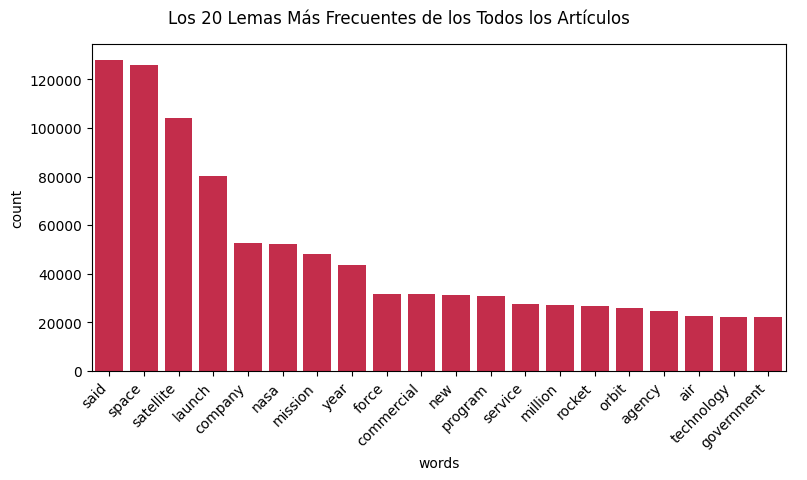

In [ ]:
gr_wcount = sns.catplot(
    data = df_sn_gr_wcount,
    x = 'words',
    y = 'count',
    kind = 'bar',
    height = 4,
    aspect = 2,
    color = 'crimson'
)

gr_wcount.fig.suptitle('Los 20 Lemas Más Frecuentes de los Todos los Artículos', y = 1.05)
gr_wcount.set_xticklabels(rotation = 45, ha = 'right')
gr_wcount.axes[0, 0].spines['top'].set_visible(True)
gr_wcount.axes[0, 0].spines['right'].set_visible(True)
plt.show()

Al encontrar lemas sueltos, aparecen algunos que no agregan ninguna información, como 'said'. Por otro lado, otros como 'new', 'year', 'force', 'million' tampoco colaboran aportando mucho significado por sí solas.

Se procede a buscar lemas en pares, o bigramas (bi-lemas), con la esperanza de capturar relaciones semánticas más ricas que podrían aportar más valor al análisis. Asimismo, se apunta a encontrar ternas (o tri-lemas).

In [ ]:
%%time
# Bigramas
common_bigrams = get_top_n_words(df_sn['content_tkn_stw_lma'], 20, 2)
for word, freq in common_bigrams:
    print(word, freq)

print()

air force 19688
space force 8559
space station 8210
space agency 6543
launch vehicle 6387
united state 5955
earth orbit 5720
chief executive 4752
low earth 4594
national security 4584
lockheed martin 4464
commercial space 4456
international space 4397
official said 3864
vice president 3784
satellite operator 3773
said company 3510
said statement 3434
small satellite 3300
blue origin 3178

CPU times: user 29 s, sys: 817 ms, total: 29.8 s
Wall time: 30 s


Una vez listados se acomodan en un `DataFrame` para visualizarlos en un gráfico.

In [ ]:
df_sn_bcount = pd.DataFrame(common_bigrams, columns = ['bigrams', 'count'])
df_sn_gr_bcount = df_sn_bcount.groupby('bigrams').sum()['count'].sort_values(ascending = False)
df_sn_gr_bcount = df_sn_gr_bcount.to_frame().reset_index()
print(df_sn_gr_bcount.head(1))

     bigrams  count
0  air force  19688


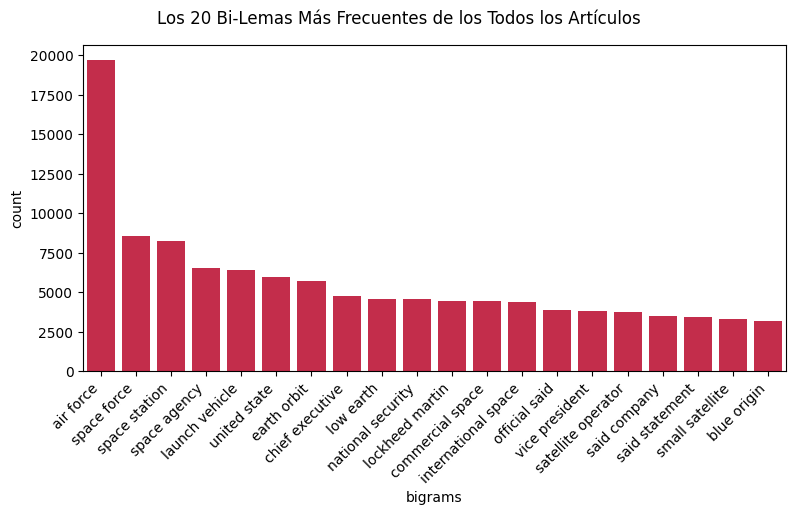

In [ ]:
gr_bcount = sns.catplot(
    data = df_sn_gr_bcount,
    x = 'bigrams',
    y = 'count',
    kind = 'bar',
    height = 4,
    aspect = 2,
    color = 'crimson'
)

gr_bcount.fig.suptitle('Los 20 Bi-Lemas Más Frecuentes de los Todos los Artículos', y = 1.05)
gr_bcount.set_xticklabels(rotation = 45, ha = 'right')
gr_bcount.axes[0, 0].spines['top'].set_visible(True)
gr_bcount.axes[0, 0].spines['right'].set_visible(True)
plt.show()

Aparecen de esta manera temáticas claramente relacionadas al ámbito de SpaceNews.com. Puede verse la preponderancia de `'air force'`, por muchos años la encargada de manejar muchos aspectos de los lanzamientos espaciales en EE.UU., hoy delegados en la `'space force'` estadounidense. Aparecen otras entidades y empresas, aunque siguen apareciendo algunos pares que no aportan gran valor semántico, como `'official said'`, `'vice president'`, `'said statement'`.

Se prosigue con las ternas o trigramas.

In [ ]:
%%time
# Trigramas
common_trigrams = get_top_n_words(df_sn['content_tkn_stw_lma'], 20, 3)
for word, freq in common_trigrams:
    print(word, freq)

print()

low earth orbit 4514
international space station 4053
european space agency 2339
united launch alliance 2106
air force space 2035
thales alenia space 1944
air force base 1398
national security space 1241
kennedy space center 1221
space development agency 1040
satellite fleet operator 1006
force space command 975
small launch vehicle 945
space missile center 939
space situational awareness 920
commercial crew program 917
space exploration technology 905
million euro million 888
earth observation satellite 851
federal aviation administration 846

CPU times: user 50.9 s, sys: 1.98 s, total: 52.9 s
Wall time: 53.6 s


Se acomodan en un `DataFrame` para lograr su visualización más tarde.

In [ ]:
df_sn_tcount = pd.DataFrame(common_trigrams, columns = ['trigrams', 'count'])
df_sn_gr_tcount = df_sn_tcount.groupby('trigrams').sum()['count'].sort_values(ascending = False)
df_sn_gr_tcount = df_sn_gr_tcount.to_frame().reset_index()
print(df_sn_gr_tcount.head(1))

          trigrams  count
0  low earth orbit   4514


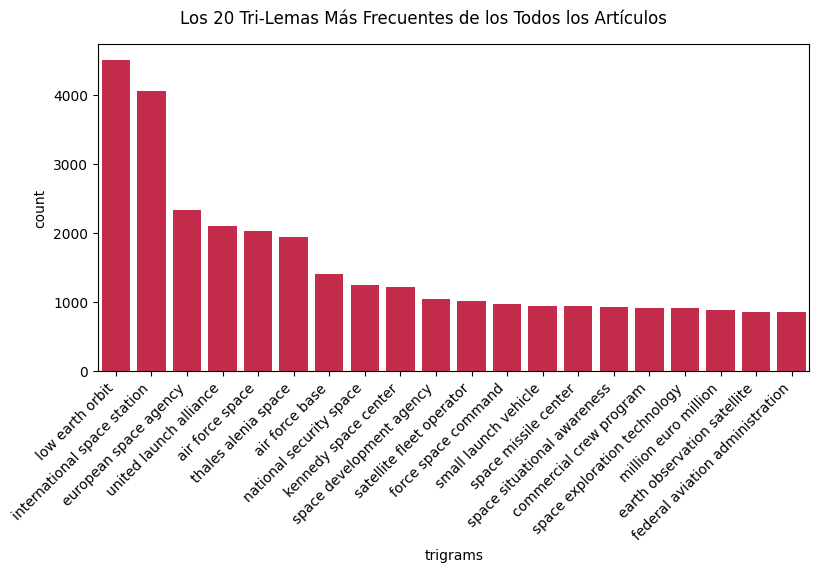

In [ ]:
gr_tcount = sns.catplot(
    data = df_sn_gr_tcount,
    x = 'trigrams',
    y = 'count',
    kind = 'bar',
    height = 4,
    aspect = 2,
    color = 'crimson'
)

gr_tcount.fig.suptitle('Los 20 Tri-Lemas Más Frecuentes de los Todos los Artículos', y = 1.05)
gr_tcount.set_xticklabels(rotation = 45, ha = 'right')
gr_tcount.axes[0, 0].spines['top'].set_visible(True)
gr_tcount.axes[0, 0].spines['right'].set_visible(True)
plt.show()

Aquí aparece `'low earth orbit'`, que es la órbita más buscada para colocar satélites o llevar astronautas a la `'international space station'`. Aparecen más agencias y empresas, como 'european space agency' o la norteamericana 'united launch alliance'. `'space exploration technology'` es la empresa *SpaceX*, posiblemente mucho más mencionada en esta última forma. Solamente el tri-lema `'million euro million'` parecería ser irrelevante, en este caso.

#### BoW desde Raíces

Se toma como base el contenido de los artículos radicalizado, midiendo frecuencias de aparición en ellos.

In [ ]:
%%time
# Raíces en todos los artículos
common_stems = get_top_n_words(df_sn['content_tkn_stw_stm'], 20, 1)
for word, freq in common_stems:
    print(word, freq)

print()

said 128020
space 125874
satellit 104144
launch 93099
compani 52479
nasa 52182
mission 47952
year 43630
orbit 39758
oper 36241
commerci 33372
forc 32839
develop 32091
new 31293
program 31219
use 29431
servic 29342
plan 28481
million 27131
rocket 26641

CPU times: user 6.58 s, sys: 44.3 ms, total: 6.63 s
Wall time: 6.64 s


Se prepara un `DataFrame` con las veinte palabras más frecuentes.

In [ ]:
# stmcnt: stem count
df_sn_stmcnt = pd.DataFrame(common_stems, columns = ['stems', 'count'])
df_sn_gr_stmcnt = df_sn_stmcnt.groupby('stems').sum()['count'].sort_values(ascending = False)
df_sn_gr_stmcnt = df_sn_gr_stmcnt.to_frame().reset_index()
print(df_sn_gr_stmcnt.head(1))

  stems   count
0  said  128020


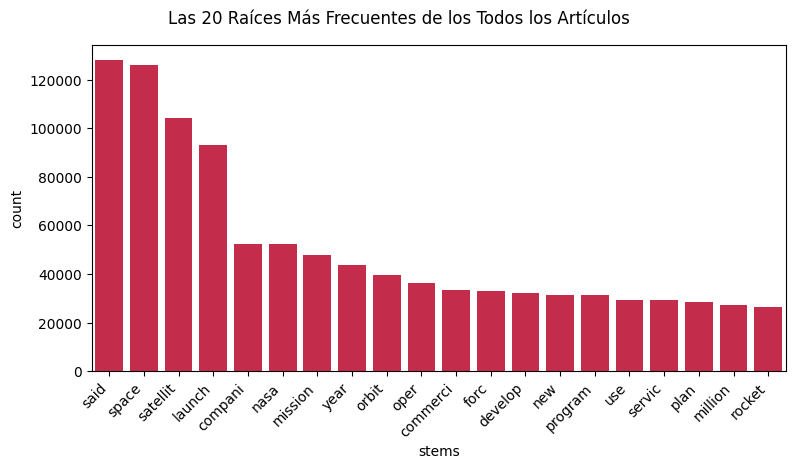

In [ ]:
gr_stmcnt = sns.catplot(
    data = df_sn_gr_stmcnt,
    x = 'stems',
    y = 'count',
    kind = 'bar',
    height = 4,
    aspect = 2,
    color = 'crimson'
)

gr_stmcnt.fig.suptitle('Las 20 Raíces Más Frecuentes de los Todos los Artículos', y = 1.05)
gr_stmcnt.set_xticklabels(rotation = 45, ha = 'right')
gr_stmcnt.axes[0, 0].spines['top'].set_visible(True)
gr_stmcnt.axes[0, 0].spines['right'].set_visible(True)
plt.show()

Como en el caso de los contenidos lematizados, al encontrar raíces sueltos, algunos no agregan información, como `'said'`. Por otro lado, otros como `'year'`, `'forc'`, `'million'` tampoco suman mucho.

Se procede a en pares, y ternas.

In [ ]:
%%time
# Bi-raíces en todos los artículos
common_bistems = get_top_n_words(df_sn['content_tkn_stw_stm'], 20, 2)
for word, freq in common_bistems:
    print(word, freq)

print()

air forc 19688
space forc 8563
space station 8210
space agenc 6542
launch vehicl 6403
unit state 5962
earth orbit 5789
satellit oper 4866
chief execut 4752
nation secur 4609
low earth 4595
commerci space 4517
lockhe martin 4464
intern space 4405
satellit launch 4347
offici said 3857
vice presid 3784
said compani 3486
said statement 3434
small satellit 3300

CPU times: user 27.3 s, sys: 558 ms, total: 27.8 s
Wall time: 28 s


Una vez listados se acomodan en un `DataFrame` para visualizarlos en un gráfico.

In [ ]:
# btmcnt: bi-stem count
df_sn_btmcnt = pd.DataFrame(common_bistems, columns = ['bistems', 'count'])
df_sn_gr_btmcnt = df_sn_btmcnt.groupby('bistems').sum()['count'].sort_values(ascending = False)
df_sn_gr_btmcnt = df_sn_gr_btmcnt.to_frame().reset_index()
print(df_sn_gr_btmcnt.head(1))

    bistems  count
0  air forc  19688


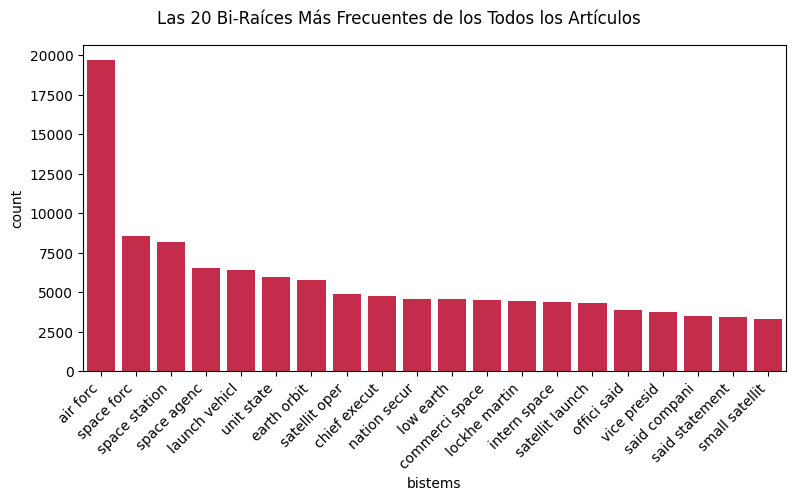

In [ ]:
gr_btmcnt = sns.catplot(
    data = df_sn_gr_btmcnt,
    x = 'bistems',
    y = 'count',
    kind = 'bar',
    height = 4,
    aspect = 2,
    color = 'crimson'
)

gr_btmcnt.fig.suptitle('Las 20 Bi-Raíces Más Frecuentes de los Todos los Artículos', y = 1.05)
gr_btmcnt.set_xticklabels(rotation = 45, ha = 'right')
gr_btmcnt.axes[0, 0].spines['top'].set_visible(True)
gr_btmcnt.axes[0, 0].spines['right'].set_visible(True)
plt.show()

Aparecen temáticas más acordes al ámbito de SpaceNews.com. Puede verse la preponderancia de `'air forc'`, por muchos años la encargada de manejar muchos aspectos de los lanzamientos espaciales en EE.UU., hoy delegados en la `'space forc'` estadounidense. Aparecen otras entidades y empresas, pero también pares de poco valor: `'offici said'`, `'vice presid'`, `'said statement'`.

Se prosigue con las ternas o tri-raíces.

In [ ]:
%%time
# Tri-raíces en todos los artículos
common_tristems = get_top_n_words(df_sn['content_tkn_stw_stm'], 20, 3)
for word, freq in common_tristems:
    print(word, freq)

print()

low earth orbit 4547
intern space station 4053
european space agenc 2339
unit launch allianc 2106
air forc space 2041
thale alenia space 1944
air forc base 1413
nation secur space 1241
kennedi space center 1221
space develop agenc 1041
satellit fleet oper 1030
forc space command 980
small launch vehicl 945
space missil center 939
space situat awar 926
commerci crew program 916
space explor technolog 905
million euro million 889
earth observ satellit 885
feder aviat administr 848

CPU times: user 49.5 s, sys: 1.65 s, total: 51.1 s
Wall time: 51.5 s


Se acomodan en un `DataFrame` para lograr su visualización más tarde.

In [ ]:
# btmcnt: tri-stem count
df_sn_ttmcnt = pd.DataFrame(common_tristems, columns = ['tristems', 'count'])
df_sn_gr_ttmcnt = df_sn_ttmcnt.groupby('tristems').sum()['count'].sort_values(ascending = False)
df_sn_gr_ttmcnt = df_sn_gr_ttmcnt.to_frame().reset_index()
print(df_sn_gr_ttmcnt.head(1))

          tristems  count
0  low earth orbit   4547


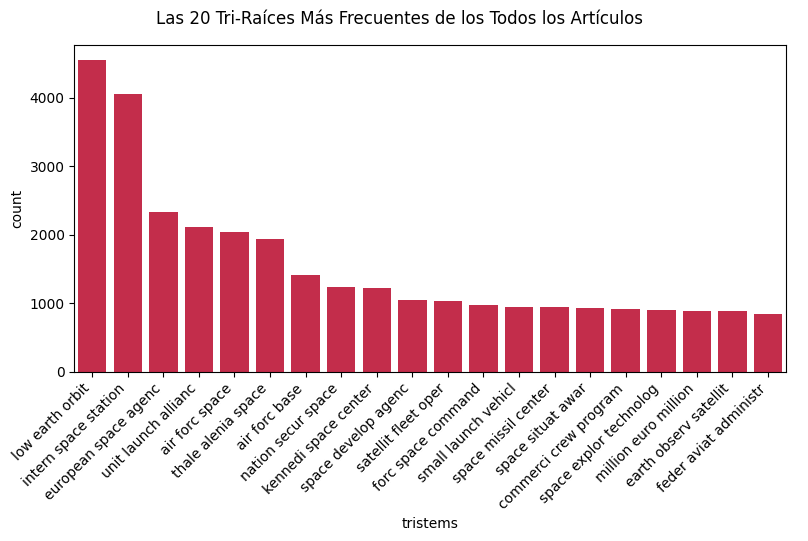

In [ ]:
gr_ttmcnt = sns.catplot(
    data = df_sn_gr_ttmcnt,
    x = 'tristems',
    y = 'count',
    kind = 'bar',
    height = 4,
    aspect = 2,
    color = 'crimson'
)

gr_ttmcnt.fig.suptitle('Las 20 Tri-Raíces Más Frecuentes de los Todos los Artículos', y = 1.05)
gr_ttmcnt.set_xticklabels(rotation = 45, ha = 'right')
gr_ttmcnt.axes[0, 0].spines['top'].set_visible(True)
gr_ttmcnt.axes[0, 0].spines['right'].set_visible(True)
plt.show()

Como se mencionó para los lemas, en tri-raíces aparece `'low earth orbit'`, `'intern space station'`, más agencias y empresas, como `'european space agenc'` o la norteamericana 'united launch alliance'. `'space explor technolog'` (*SpaceX*). La tri-raíz `'million euro million'` parecería ser irrelevante.

Seguidamente se realizan comparaciones entre unidades, pares y ternas, de modo de responder a esta cuestión: ¿los lemas y raíces que aparecen, lo hacen con igual frecuencia? Por ende, ¿están listados en la misma posición del top 20?

In [ ]:
df_sn_lvss_simple = pd.concat(
    [
        df_sn_gr_wcount.rename(columns = {'count': 'ls_count'}), # ls: lemma simple
        df_sn_gr_stmcnt.rename(columns = {'count': 'ss_count'})  # ss: stem simple
    ],
    axis = 1
)
print(df_sn_lvss_simple)

         words  ls_count     stems  ss_count
0         said    128020      said    128020
1        space    125784     space    125874
2    satellite    104113  satellit    104144
3       launch     80034    launch     93099
4      company     52479   compani     52479
5         nasa     52182      nasa     52182
6      mission     47949   mission     47952
7         year     43592      year     43630
8        force     31830     orbit     39758
9   commercial     31769      oper     36241
10         new     31290  commerci     33372
11     program     31020      forc     32839
12     service     27505   develop     32091
13     million     27131       new     31293
14      rocket     26634   program     31219
15       orbit     25906       use     29431
16      agency     24666    servic     29342
17         air     22442      plan     28481
18  technology     22067   million     27131
19  government     22030    rocket     26641


Vemos que hasta `'year'` van emparejados, aunque con distintas cantidades. Sin embargo, a partir de la siguiente palabra hay desalineamientos entre lemas y raíces.

In [ ]:
df_sn_lvss_double = pd.concat(
    [
        df_sn_gr_bcount.rename(columns = {'count': 'ld_count'}), # ls: lemma double (bi)
        df_sn_gr_btmcnt.rename(columns = {'count': 'sd_count'})  # ss: stem double (bi)
    ],
    axis = 1
)
print(df_sn_lvss_double)

                bigrams  ld_count          bistems  sd_count
0             air force     19688         air forc     19688
1           space force      8559       space forc      8563
2         space station      8210    space station      8210
3          space agency      6543      space agenc      6542
4        launch vehicle      6387    launch vehicl      6403
5          united state      5955       unit state      5962
6           earth orbit      5720      earth orbit      5789
7       chief executive      4752    satellit oper      4866
8             low earth      4594     chief execut      4752
9     national security      4584     nation secur      4609
10      lockheed martin      4464        low earth      4595
11     commercial space      4456   commerci space      4517
12  international space      4397    lockhe martin      4464
13        official said      3864     intern space      4405
14       vice president      3784  satellit launch      4347
15   satellite operator 

En este caso, el fenómeno se presenta luego de 'earth orbit'.

In [ ]:
df_sn_lvss_triple = pd.concat(
    [
        df_sn_gr_tcount.rename(columns = {'count': 'lt_count'}), # lt: lemma triple (tri)
        df_sn_gr_ttmcnt.rename(columns = {'count': 'st_count'})  # st: stem triple (tri)
    ],
    axis = 1
)
print(df_sn_lvss_triple)

                           trigrams  lt_count                tristems  st_count
0                   low earth orbit      4514         low earth orbit      4547
1       international space station      4053    intern space station      4053
2             european space agency      2339    european space agenc      2339
3            united launch alliance      2106     unit launch allianc      2106
4                   air force space      2035          air forc space      2041
5               thales alenia space      1944      thale alenia space      1944
6                    air force base      1398           air forc base      1413
7           national security space      1241      nation secur space      1241
8              kennedy space center      1221    kennedi space center      1221
9          space development agency      1040     space develop agenc      1041
10         satellite fleet operator      1006     satellit fleet oper      1030
11              force space command     

En ese caso, aunque cambian las cuentas, si están emparejadas las ternas de los lemas con las de las raíces. Posiblemente se deba a la mayor dificultad de que tres raíces puedan considerarse algo distinto a sus tres lemas correspondientes.

### Vectorización TF-IDF

Se busca encontrar las palabras más frecuentes, pero más relevantes para cada artículo, utilizando para ello `TfidfVectorizer` de `sklearn`. Esto es de gran utilidad para encontrar patrones en el texto, mejorando su análisis.

#### TF-IDF desde Lemas

Se toma como base el contenido de los artículos lematizado, midiendo frecuencias de aparición en ellos y frecuencias inversas en cada artículo.

In [ ]:
%%time
# Unión de lemas en cadena única por artículo
df_sn['content_lma_str'] = df_sn['content_tkn_stw_lma'].apply(lambda x: ' '.join(x))

# Strings unidos, encabezado
print(df_sn['content_lma_str'].head())
print()

0    los angeles rocket lab launched first two nasa...
1    washington space development agency sda announ...
2    tampa fla amazon web service busy positioning ...
3    los angeles spacex set june launch date next s...
4    los angeles nasa boeing preparing june launch ...
Name: content_lma_str, dtype: object

CPU times: user 227 ms, sys: 1.96 ms, total: 228 ms
Wall time: 231 ms


In [ ]:
# Strings unidos, pie
print(df_sn['content_lma_str'].tail())

20710    frank kendall pentagon top acquisition officia...
20711    updated feb pm eastern u national oceanic atmo...
20712    washington nasa develops longterm strategy sup...
20713    washington spending bill house passed june wou...
20714    u rep jim bridenstine rokla growing presence w...
Name: content_lma_str, dtype: object


Se considerarán 500 características, por una cuestión de reducción de dimensionalidad, lo que impacta directamente en el costo computacional. Por otro lado, tener relativamente pocas características para alimentar al modeo puede colaborar en reducir el sobreajuste.

In [ ]:
%%time
# Objeto TF-IDF
tfidf_content_l = TfidfVectorizer(
    max_features = 500,
    stop_words = stopwords.words('english')
)

tfidf_con_matrix_l = tfidf_content_l.fit_transform(df_sn['content_lma_str'])

# Conversión de matrices en DataFrames
df_tfidf_l = pd.DataFrame(
    tfidf_con_matrix_l.toarray(),
    columns = tfidf_content_l.get_feature_names_out()
)

CPU times: user 6.99 s, sys: 145 ms, total: 7.13 s
Wall time: 7.14 s


In [ ]:
# TF-IDF, encabezado
print(df_tfidf_l.head())

    ability     able  aboard  access  according  acquisition  across  act  activity     added  addition  additional  administration  administrator  advanced  aerospace    agency       ago  agreement  air  airbus  allow   already      also  although  american  among  announced   another  antenna  application  approach    april      area  ariane    around  asteroid  astronaut     atlas  aug  available     award      back  base     based  begin    better  beyond  bill   billion  blue  board    boeing  broadband    budget    build  building  built  business  california      call    called  capability  capacity  cargo     carry      case    center  ceo  challenge    change     chief  china  chinese      come    coming   command  commercial  commission  committee  communication  community  \
0  0.000000  0.00000     0.0     0.0   0.000000          0.0     0.0  0.0       0.0  0.000000  0.000000    0.000000        0.000000            0.0  0.000000   0.000000  0.000000  0.000000        0.0  0.0

In [ ]:
# TF-IDF, pie
print(df_tfidf_l.tail())

        ability      able  aboard    access  according  acquisition  across       act  activity  added  addition  additional  administration  administrator  advanced  aerospace    agency       ago  agreement       air  airbus  allow   already      also  although  american  among  announced   another  antenna  application  approach  april  area  ariane    around  asteroid  astronaut     atlas  aug  available  award  back  base     based     begin    better    beyond      bill   billion      blue  board  boeing  broadband    budget     build  building     built  business  california  call  called  capability  capacity  cargo     carry      case    center  ceo  challenge    change     chief  china  chinese      come    coming   command  commercial  commission  committee  communication  \
20710  0.000000  0.000000     0.0  0.114092   0.000000     0.253210     0.0  0.000000  0.000000    0.0       0.0    0.000000        0.000000            0.0  0.124264        0.0  0.000000  0.000000    0.00

#### TF-IDF desde Raíces

Se toma como base el contenido de los artículos radicalizado, midiendo frecuencias de aparición en ellos y frecuencias inversas en cada artículo.

In [ ]:
%%time
# Unión de raíces en cadena única por artículo
df_sn['content_stm_str'] = df_sn['content_tkn_stw_stm'].apply(lambda x: ' '.join(x))

# Strings unidos, encabezado
print(df_sn['content_stm_str'].head())
print()

0    los angel rocket lab launch first two nasa ear...
1    washington space develop agenc sda announc pla...
2    tampa fla amazon web servic busi posit cloud i...
3    los angel spacex set june launch date next sta...
4    los angel nasa boe prepar june launch compani ...
Name: content_stm_str, dtype: object

CPU times: user 192 ms, sys: 0 ns, total: 192 ms
Wall time: 195 ms


In [ ]:
# Strings unidos, pie
print(df_sn['content_stm_str'].tail())

20710    frank kendal pentagon top acquisit offici spok...
20711    updat feb pm eastern us nation ocean atmospher...
20712    washington nasa develop longterm strategi supp...
20713    washington spend bill hous pass june would giv...
20714    us rep jim bridenstin rokla grow presenc washi...
Name: content_stm_str, dtype: object


500 características, reduciendo dimensionalidad, como se explicó anteriormente.

In [ ]:
%%time
# Objeto TF-IDF
tfidf_content_s = TfidfVectorizer(
    max_features = 500,
    stop_words = stopwords.words('english')
)

tfidf_con_matrix_s = tfidf_content_s.fit_transform(df_sn['content_lma_str'])

# Conversión de matrices en DataFrames
df_tfidf_s = pd.DataFrame(
    tfidf_con_matrix_s.toarray(),
    columns = tfidf_content_s.get_feature_names_out()
)

CPU times: user 11.1 s, sys: 219 ms, total: 11.3 s
Wall time: 11.6 s


In [ ]:
# TF-IDF, encabezado
print(df_tfidf_s.head())

    ability     able  aboard  access  according  acquisition  across  act  activity     added  addition  additional  administration  administrator  advanced  aerospace    agency       ago  agreement  air  airbus  allow   already      also  although  american  among  announced   another  antenna  application  approach    april      area  ariane    around  asteroid  astronaut     atlas  aug  available     award      back  base     based  begin    better  beyond  bill   billion  blue  board    boeing  broadband    budget    build  building  built  business  california      call    called  capability  capacity  cargo     carry      case    center  ceo  challenge    change     chief  china  chinese      come    coming   command  commercial  commission  committee  communication  community  \
0  0.000000  0.00000     0.0     0.0   0.000000          0.0     0.0  0.0       0.0  0.000000  0.000000    0.000000        0.000000            0.0  0.000000   0.000000  0.000000  0.000000        0.0  0.0

In [ ]:
# TF-IDF, pie
print(df_tfidf_s.tail())

        ability      able  aboard    access  according  acquisition  across       act  activity  added  addition  additional  administration  administrator  advanced  aerospace    agency       ago  agreement       air  airbus  allow   already      also  although  american  among  announced   another  antenna  application  approach  april  area  ariane    around  asteroid  astronaut     atlas  aug  available  award  back  base     based     begin    better    beyond      bill   billion      blue  board  boeing  broadband    budget     build  building     built  business  california  call  called  capability  capacity  cargo     carry      case    center  ceo  challenge    change     chief  china  chinese      come    coming   command  commercial  commission  committee  communication  \
20710  0.000000  0.000000     0.0  0.114092   0.000000     0.253210     0.0  0.000000  0.000000    0.0       0.0    0.000000        0.000000            0.0  0.124264        0.0  0.000000  0.000000    0.00

#### Punto de Control

Este punto de control permite guardar en Google Drive lo hecho hasta el momento.

In [ ]:
# Nombre del archivo
name_df_nlptasks = 'df_sn_nlptasks.feather'

In [ ]:
# Guardado, sobreescritura según existencia de archivo
if os.path.exists(folder_df_initial + name_df_nlptasks):
    inp_aswr = input(f'Archivo "{name_df_nlptasks}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió.')
    else:
        df_sn.to_feather(folder_df_initial + name_df_nlptasks)
        print('Se sobreescribió.')
else:
    df_sn.to_feather(folder_df_initial + name_df_nlptasks)
    print('Archivo guardado.')

Archivo "df_sn_nlptasks.feather" ya existente. ¿Sobrescribirlo? (s/n): n
No se sobreescribió.


In [ ]:
# Nombre del archivo
name_df_tfidf_l = 'df_tfidf_l.feather'

In [ ]:
# Guardado, sobreescritura según existencia de archivo
if os.path.exists(folder_df_initial + name_df_tfidf_l):
    inp_aswr = input(f'Archivo "{name_df_tfidf_l}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió.')
    else:
        df_tfidf_l.to_feather(folder_df_initial + name_df_tfidf_l)
        print('Se sobreescribió.')
else:
    df_tfidf_l.to_feather(folder_df_initial + name_df_tfidf_l)
    print('Archivo guardado.')

Archivo "df_tfidf_l.feather" ya existente. ¿Sobrescribirlo? (s/n): n
No se sobreescribió.


In [ ]:
# Nombre del archivo para el DataFrame df_tfidf_s
name_df_tfidf_s = 'df_tfidf_s.feather'

In [ ]:
# Guardado, sobreescritura según existencia de archivo
if os.path.exists(folder_df_initial + name_df_tfidf_s):
    inp_aswr = input(f'Archivo "{name_df_tfidf_s}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió.')
    else:
        df_tfidf_s.to_feather(folder_df_initial + name_df_tfidf_s)
        print('Se sobreescribió.')
else:
    df_tfidf_s.to_feather(folder_df_initial + name_df_tfidf_s)
    print('Archivo guardado.')

Archivo "df_tfidf_s.feather" ya existente. ¿Sobrescribirlo? (s/n): n
No se sobreescribió.


Desde la siguiente celda se puede cargar los `DataFrames` con el conjunto de datos y su preprocesamiento (`df_sn`), y con la aplicación de TF-IDF Vectorizer tras lematización (`df_tfidf_l`) y tras radicalización (`df_tfidf_s`).

Esto permite saltear la ejecución de una buena cantidad de celdas. Es necesario, previamente, ejecutar todo el código dentro del encabezado 'Recursos'.

In [ ]:
'''
### CARGA DESDE PUNTO DE CONTROL

%%time

folder_df_initial = '/content/drive/My Drive/'
name_df_nlptasks = 'df_sn_nlptasks.feather'
name_df_tfidf_l = 'df_tfidf_l.feather'
name_df_tfidf_s = 'df_tfidf_s.feather'
name_df_top10writers = 'df_sn_top10writers.feather'

df_sn = pd.read_feather(folder_df_initial + name_df_nlptasks)
print('Archivo de DataFrame "nlptasks" cargado.')
print()
df_tfidf_l = pd.read_feather(folder_df_initial + name_df_tfidf_l)
print('Archivo de DataFrame "tfidf_l" cargado.')
print()
df_tfidf_s = pd.read_feather(folder_df_initial + name_df_tfidf_s)
print('Archivo de DataFrame "tfidf_s" cargado.')
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
print(df_sn.head())
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
print(df_tfidf_l.head())
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
print(df_tfidf_s.head())
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
df_sn_top10writers = pd.read_feather(folder_df_initial + name_df_top10writers)
print('Archivo de DataFrame "top10writers" cargado.')
print()
'''

## Aprendizaje Automático

Tras haber preprocesado el contenido de los artículos de SpaceNews.com, se intentará entrenar modelos de aprendizaje supervisado que puedan predecir si un texto que se le muestre sigue el estilo de uno de los escritores del sitio. De este modo, se busca lograr la detección de posibles plagios.

Para este primer producto encargado por SpaceNews.com, se trabajará con los diez escritores más prolíficos.

### Preparación

Inicialmente se prepararán los datos para ser alimentados a los distintos modelos.

Tener presente que el código bajo el presente encabezado es necesario también para la ejecución del código bajo el encabezado 'Aprendizaje Profundo'.

Verificación de alineación de índices: es decir, que tengan idénticos índices.

In [ ]:
print('Alineación de índices para "df_tfidf_l":', df_tfidf_l.index.equals(df_sn.index))
print('Alineación de índices para "df_tfidf_s":', df_tfidf_s.index.equals(df_sn.index))

Alineación de índices para "df_tfidf_l": True
Alineación de índices para "df_tfidf_s": True


In [ ]:
print('Forma del `DataFrame` df_tfidf_l:', df_tfidf_l.shape)
print('Forma del `DataFrame` df_tfidf_s:', df_tfidf_s.shape)

Forma del `DataFrame` df_tfidf_l: (20715, 500)
Forma del `DataFrame` df_tfidf_s: (20715, 500)


Los diez escritores más prolíficos del sitio.

In [ ]:
df_sn_top10writers['author'].to_list()

['Jeff Foust',
 'Sandra Erwin',
 'Peter B. de Selding',
 'Debra Werner',
 'Caleb Henry',
 'SpaceNews Staff',
 'Jason Rainbow',
 'Dan Leone',
 'Mike Gruss',
 'Andrew Jones']

Se filtra el `DataFrame` principal para que solo contenga registros correspondientes a estos diez escritores.

In [ ]:
df_sn_fauthor = df_sn[df_sn['author'].isin(df_sn_top10writers['author'].to_list())]
print(df_sn_fauthor.shape)
print()
print(df_sn_fauthor.head())

(17283, 12)

                                               title                                                url                                            content         author       date  content_len                                        content_tkn                                    content_tkn_stw                                content_tkn_stw_lma                                content_tkn_stw_stm                                    content_lma_str                                    content_stm_str
0  Electron launches first NASA PREFIRE Earth sci...  https://spacenews.com/electron-launches-first-...  los angeles  rocket lab launched the first of ...     Jeff Foust 2024-05-25         3218  [los, angeles, rocket, lab, launched, the, fir...  [los, angeles, rocket, lab, launched, first, t...  [los, angeles, rocket, lab, launched, first, t...  [los, angel, rocket, lab, launch, first, two, ...  los angeles rocket lab launched first two nasa...  los angel rocket lab launch first two

Codificación de etiquetas.

In [ ]:
# Codificar las etiquetas
label_encoder_y = LabelEncoder()
y = df_sn_fauthor['author']
y_encoded = label_encoder_y.fit_transform(y)

Preparación y división en subconjuntos de entrenamiento y prueba.

In [ ]:
# Filtrado en características desde lemas
df_tfidf_f_l = df_tfidf_l.loc[df_tfidf_l.index.isin(df_sn_fauthor.index)]
# Características
X_l = df_tfidf_f_l
# División entrenamiento/prueba
X_l_train, X_l_test, y_train, y_test = train_test_split(
    X_l,
    y_encoded,
    test_size = 0.2,
    random_state = 404
)

In [ ]:
# Filtrado en características desde raíces
df_tfidf_f_s = df_tfidf_s.loc[df_tfidf_s.index.isin(df_sn_fauthor.index)]
# Características
X_s = df_tfidf_f_s
# División entrenamiento/prueba
X_s_train, X_s_test, y_train, y_test = train_test_split(
    X_s,
    y_encoded,
    test_size = 0.2,
    random_state = 404
)

### Regresión Logística

En primer lugar se prueba con un modelo de clasificación regresión logística multiclase.

#### Desde Lemas

Este modelo se alimenta con las características surgidas de aplicar TF-IDF Vectorizer al contenido preprocesado y lematizado.

In [ ]:
%%time
# Modelo clasificador
model_log_l = LogisticRegression(max_iter = 1000)
# Entrenamiento
model_log_l.fit(X_l_train, y_train)

CPU times: user 6.45 s, sys: 1.44 s, total: 7.89 s
Wall time: 7.35 s


LogisticRegression(max_iter=1000)

Se realizan predicciones.

In [ ]:
# Predicciones sobre entrenamiento
y_pred_train = model_log_l.predict(X_l_train)
# Evaluación
report_log_l_trn = classification_report(
    y_train,
    y_pred_train,
    output_dict = True,
    zero_division = 0
)

In [ ]:
# Predicciones sobre prueba
y_pred = model_log_l.predict(X_l_test)
# Evaluación
report_log_l_tst = classification_report(
    y_test,
    y_pred,
    output_dict = True,
    zero_division = 0
)

Se evalúa el rendimiento.

In [ ]:
# Evaluación sobre conjunto de entrenamiento
# Métricas generales
metrics = {
    'nlp_task': 'lemma',
    'model': 'log regr',
    'h_param': '-',
    'hprm_val': '-',
    'f1-score_w_avg': report_log_l_trn['weighted avg']['f1-score'],
    'f1-score_m_avg': report_log_l_trn['macro avg']['f1-score'],
    'accuracy': report_log_l_trn['accuracy']
}
# F1-scores por clase
for label in report_log_l_trn:
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        metrics[f'f1-score_cl_{label}'] = report_log_l_trn[label]['f1-score']
# A DataFrame
df_metrics_log_l_trn = pd.DataFrame([metrics])

In [ ]:
# Evaluación sobre conjunto de prueba
# Métricas generales
metrics = {
    'nlp_task': 'lemma',
    'model': 'log regr',
    'h_param': '-',
    'hprm_val': '-',
    'f1-score_w_avg': report_log_l_tst['weighted avg']['f1-score'],
    'f1-score_m_avg': report_log_l_tst['macro avg']['f1-score'],
    'accuracy': report_log_l_tst['accuracy']
}
# F1-scores por clase
for label in report_log_l_tst:
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        metrics[f'f1-score_cl_{label}'] = report_log_l_tst[label]['f1-score']
# A DataFrame
df_metrics_log_l_tst = pd.DataFrame([metrics])

In [ ]:
# Impresión comparando entrenamiento contra prueba
print(pd.concat([df_metrics_log_l_trn, df_metrics_log_l_tst], axis = 0))

  nlp_task     model h_param hprm_val  f1-score_w_avg  f1-score_m_avg  accuracy  f1-score_cl_0  f1-score_cl_1  f1-score_cl_2  f1-score_cl_3  f1-score_cl_4  f1-score_cl_5  f1-score_cl_6  f1-score_cl_7  f1-score_cl_8  f1-score_cl_9
0    lemma  log regr       -        -        0.898583        0.866137  0.901490       0.940022       0.858869       0.828364       0.865146       0.881381       0.945715       0.820261       0.934359       0.928780       0.658477
0    lemma  log regr       -        -        0.866595        0.824141  0.872433       0.931818       0.804444       0.748252       0.818620       0.887052       0.925457       0.823899       0.918002       0.902946       0.480916


Guardados del modelo y de sus métricas.

In [ ]:
# Guardado del modelo
model_log_l_name = 'model_log_l.pkl'
if os.path.exists(folder_df_initial + model_log_l_name):
    inp_aswr = input(f'Archivo "{model_log_l_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el modelo.')
    else:
        with open(folder_df_initial + model_log_l_name, 'wb') as f:
            pickle.dump(model_log_l, f)
        print('Modelo sobreescrito.')
else:
    with open(folder_df_initial + model_log_l_name, 'wb') as f:
        pickle.dump(model_log_l, f)
    print('Modelo guardado.')

Archivo "model_log_l.pkl" ya existente. ¿Sobrescribirlo? (s/n): n
No se sobreescribió el modelo.


In [ ]:
# Guardado de métricas de entrenamiento
metrics_log_l_trn_name = 'df_metrics_log_l_trn.feather'
if os.path.exists(folder_df_initial + metrics_log_l_trn_name):
    inp_aswr = input(f'Archivo "{metrics_log_l_trn_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de entrenamiento.')
    else:
        df_metrics_log_l_trn.to_feather(folder_df_initial + metrics_log_l_trn_name)
        print('DataFrame de métricas de entrenamiento sobreescrito.')
else:
    df_metrics_log_l_trn.to_feather(folder_df_initial + metrics_log_l_trn_name)
    print('DataFrame de métricas de entrenamiento guardado.')

Archivo "df_metrics_log_l_trn.feather" ya existente. ¿Sobrescribirlo? (s/n): n
No se sobreescribió el DataFrame de métricas de entrenamiento.


In [ ]:
# Guardado de métricas de prueba
metrics_log_l_tst_name = 'df_metrics_log_l_tst.feather'
if os.path.exists(folder_df_initial + metrics_log_l_tst_name):
    inp_aswr = input(f'Archivo "{metrics_log_l_tst_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de prueba.')
    else:
        df_metrics_log_l_tst.to_feather(folder_df_initial + metrics_log_l_tst_name)
        print('DataFrame de métricas de prueba sobreescrito.')
else:
    df_metrics_log_l_tst.to_feather(folder_df_initial + metrics_log_l_tst_name)
    print('DataFrame de métricas de prueba guardado.')

Archivo "df_metrics_log_l_tst.feather" ya existente. ¿Sobrescribirlo? (s/n): n
No se sobreescribió el DataFrame de métricas de prueba.


#### Desde Raíces

Este modelo se alimenta con las características surgidas de aplicar TF-IDF Vectorizer al contenido preprocesado y radicalizado.

In [ ]:
%%time
# Modelo clasificador
model_log_s = LogisticRegression(max_iter = 1000)
# Entrenamiento
model_log_s.fit(X_s_train, y_train)

CPU times: user 5.41 s, sys: 593 ms, total: 6 s
Wall time: 3.13 s


LogisticRegression(max_iter=1000)

Se realizan predicciones.

In [ ]:
# Predicciones sobre entrenamiento
y_pred_train = model_log_s.predict(X_s_train)
# Evaluación
report_log_s_trn = classification_report(
    y_train,
    y_pred_train,
    output_dict = True,
    zero_division = 0
)

In [ ]:
# Predicciones sobre prueba
y_pred_test = model_log_s.predict(X_s_test)
# Evaluación
report_log_s_tst = classification_report(
    y_test,
    y_pred_test,
    output_dict = True,
    zero_division = 0
)

Se evalúa el rendimiento.

In [ ]:
# Evaluación sobre conjunto de entrenamiento
# Métricas generales
metrics = {
    'nlp_task': 'stem',
    'model': 'log regr',
    'h_param': '-',
    'hprm_val': '-',
    'f1-score_w_avg': report_log_s_trn['weighted avg']['f1-score'],
    'f1-score_m_avg': report_log_s_trn['macro avg']['f1-score'],
    'accuracy': report_log_s_trn['accuracy']
}
# F1-scores por clase
for label in report_log_s_trn:
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        metrics[f'f1-score_cl_{label}'] = report_log_s_trn[label]['f1-score']
# A DataFrame
df_metrics_log_s_trn = pd.DataFrame([metrics])

In [ ]:
# Evaluación sobre conjunto de prueba
# Métricas generales
metrics = {
    'nlp_task': 'stem',
    'model': 'log regr',
    'h_param': '-',
    'hprm_val': '-',
    'f1-score_w_avg': report_log_s_tst['weighted avg']['f1-score'],
    'f1-score_m_avg': report_log_s_tst['macro avg']['f1-score'],
    'accuracy': report_log_s_tst['accuracy']
}
# F1-scores por clase
for label in report_log_s_tst:
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        metrics[f'f1-score_cl_{label}'] = report_log_s_tst[label]['f1-score']
# A DataFrame
df_metrics_log_s_tst = pd.DataFrame([metrics])

In [ ]:
# Impresión comparando entrenamiento contra prueba
print(pd.concat([df_metrics_log_s_trn, df_metrics_log_s_tst], axis = 0))

  nlp_task     model h_param hprm_val  f1-score_w_avg  f1-score_m_avg  accuracy  f1-score_cl_0  f1-score_cl_1  f1-score_cl_2  f1-score_cl_3  f1-score_cl_4  f1-score_cl_5  f1-score_cl_6  f1-score_cl_7  f1-score_cl_8  f1-score_cl_9
0     stem  log regr       -        -        0.898583        0.866137  0.901490       0.940022       0.858869       0.828364       0.865146       0.881381       0.945715       0.820261       0.934359       0.928780       0.658477
0     stem  log regr       -        -        0.866595        0.824141  0.872433       0.931818       0.804444       0.748252       0.818620       0.887052       0.925457       0.823899       0.918002       0.902946       0.480916


Guardados del modelo y de sus métricas.

In [ ]:
# Guardado del modelo
model_log_s_name = 'model_log_s.pkl'
if os.path.exists(folder_df_initial + model_log_s_name):
    inp_aswr = input(f'Archivo "{model_log_s_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el modelo.')
    else:
        with open(folder_df_initial + model_log_s_name, 'wb') as f:
            pickle.dump(model_log_s, f)
        print('Modelo sobreescrito.')
else:
    with open(folder_df_initial + model_log_s_name, 'wb') as f:
        pickle.dump(model_log_s, f)
    print('Modelo guardado.')

Modelo guardado.


In [ ]:
# Guardado de métricas de entrenamiento
metrics_log_s_trn_name = 'df_metrics_log_s_trn.feather'
if os.path.exists(folder_df_initial + metrics_log_s_trn_name):
    inp_aswr = input(f'Archivo "{metrics_log_s_trn_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de entrenamiento.')
    else:
        df_metrics_log_s_trn.to_feather(folder_df_initial + metrics_log_s_trn_name)
        print('DataFrame de métricas de entrenamiento sobreescrito.')
else:
    df_metrics_log_s_trn.to_feather(folder_df_initial + metrics_log_s_trn_name)
    print('DataFrame de métricas de entrenamiento guardado.')

DataFrame de métricas de entrenamiento guardado.


In [ ]:
# Guardado de métricas de prueba
metrics_log_s_tst_name = 'df_metrics_log_s_tst.feather'
if os.path.exists(folder_df_initial + metrics_log_s_tst_name):
    inp_aswr = input(f'Archivo "{metrics_log_s_tst_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de prueba.')
    else:
        df_metrics_log_s_tst.to_feather(folder_df_initial + metrics_log_s_tst_name)
        print('DataFrame de métricas de prueba sobreescrito.')
else:
    df_metrics_log_s_tst.to_feather(folder_df_initial + metrics_log_s_tst_name)
    print('DataFrame de métricas de prueba guardado.')

DataFrame de métricas de prueba guardado.


#### Punto de Control

En este punto de control puede cargarse tanto los modelos de regresión logística, como los `DataFrames` con sus respectivas métricas de entrenamiento y de prueba.

El uso de este punto de control resulta de utilidad para ejecutar código bajo el encabezado 'Selección del Modelo' sin necesidad de ejecutar todas y cada una de las líneas de código que le preceden.

Archivos de regresión logística desde lemas.

In [ ]:
'''
### CARGA DESDE PUNTO DE CONTROL

folder_df_initial = '/content/drive/My Drive/'

# Carga de modelo
model_log_l_name = 'model_log_l.pkl'
with open(folder_df_initial + model_log_l_name, 'rb') as f:
    model_log_l = pickle.load(f)
print('Modelo cargado.')

# Carga de métricas de entrenamiento
metrics_log_l_trn_name = 'df_metrics_log_l_trn.feather'
df_metrics_log_l_trn = pd.read_feather(folder_df_initial + metrics_log_l_trn_name)
print('DataFrame de métricas de entrenamiento cargado.')

# Carga de métricas de prueba
metrics_log_l_tst_name = 'df_metrics_log_l_tst.feather'
df_metrics_log_l_tst = pd.read_feather(folder_df_initial + metrics_log_l_tst_name)
print('DataFrame de métricas de prueba cargado.')
'''

Archivos de regresión logística desde raíces.

In [ ]:
'''
### CARGA DESDE PUNTO DE CONTROL

folder_df_initial = '/content/drive/My Drive/'

# Carga de modelo
model_log_s_name = 'model_log_s.pkl'
with open(folder_df_initial + model_log_s_name, 'rb') as f:
    model_log_s = pickle.load(f)
print('Modelo cargado.')

# Carga de métricas de entrenamiento
metrics_log_s_trn_name = 'df_metrics_log_s_trn.feather'
df_metrics_log_s_trn = pd.read_feather(folder_df_initial + metrics_log_s_trn_name)
print('DataFrame de métricas de entrenamiento cargado.')

# Carga de métricas de prueba
metrics_log_s_tst_name = 'df_metrics_log_s_tst.feather'
df_metrics_log_s_tst = pd.read_feather(folder_df_initial + metrics_log_s_tst_name)
print('DataFrame de métricas de prueba cargado.')
'''

### Vecinos Cercanos

Aquí se aplica un clasificador multiclase por vecinos cercanos.

#### Desde Lemas

Este modelo se alimenta con las características surgidas de aplicar TF-IDF Vectorizer al contenido preprocesado y lematizado.

Mediante un ciclo, se entrenan modelos para distintos valores de vecinos cercanos, buscndo lograr así una mejor predición.

Se realiza el entrenamiento iterativo.

In [ ]:
%%time
# Lista de modelos
models_knn_l = []
# Valores de k
k_values = [3, 5, 8, 12, 16, 20]
# Entrenamiento de modelos con diferentes k
for k in k_values:
    print(f'kNN con k = {k}')
    model_knn = KNeighborsClassifier(n_neighbors = k)
    model_knn.fit(X_l_train, y_train)
    # Guardado en lista
    models_knn_l.append(model_knn)
print('Entrenamientos finalizados.')
print()

kNN con k = 3
kNN con k = 5
kNN con k = 8
kNN con k = 12
kNN con k = 16
kNN con k = 20
Entrenamientos finalizados.

CPU times: user 275 ms, sys: 106 ms, total: 381 ms
Wall time: 422 ms


Se predice y se evalúa el rendimiento en entrenamiento.

In [ ]:
%%time
# Lista para reportes de entrenamiento
reports_knn_l_trn = []

# Evaluación de cada modelo
for i, model in enumerate(models_knn_l):
    print(f'Evaluando kNN con k = {k_values[i]}')
    # Predicciones sobre el conjunto de entrenamiento
    y_pred_train = model.predict(X_l_train)
    # Evaluación
    report_knn_trn = classification_report(
        y_train,
        y_pred_train,
        output_dict = True,
        zero_division = 0
    )
    # Guardado de reporte en lista
    reports_knn_l_trn.append(report_knn_trn)

print('Evaluaciones de entrenamiento finalizadas.')
print()

Evaluando kNN con k = 3
Evaluando kNN con k = 5
Evaluando kNN con k = 8
Evaluando kNN con k = 12
Evaluando kNN con k = 16
Evaluando kNN con k = 20
Evaluaciones de entrenamiento finalizadas.

CPU times: user 50.1 s, sys: 210 ms, total: 50.3 s
Wall time: 51 s


Se predice y se evalúa el rendimiento en prueba.

In [ ]:
%%time
# Lista para reportes de prueba
reports_knn_l_tst = []

# Evaluación de cada modelo
for i, model in enumerate(models_knn_l):
    print(f'Evaluando kNN con k = {k_values[i]}')
    # Predicciones sobre el conjunto de prueba
    y_pred_test = model.predict(X_l_test)
    # Evaluación
    report_knn_tst = classification_report(
        y_test,
        y_pred_test,
        output_dict = True,
        zero_division = 0
    )
    # Guardado de reporte en lista
    reports_knn_l_tst.append(report_knn_tst)

print('Evaluaciones de prueba finalizadas.')
print()

Evaluando kNN con k = 3
Evaluando kNN con k = 5
Evaluando kNN con k = 8
Evaluando kNN con k = 12
Evaluando kNN con k = 16
Evaluando kNN con k = 20
Evaluaciones de prueba finalizadas.

CPU times: user 13 s, sys: 53.4 ms, total: 13.1 s
Wall time: 13.2 s


Se recopilan las métricas de entrenamiento.

In [ ]:
%%time
# Lista de métricas de entrenamiento
all_metrics_knn_l = []
# Extracción de métricas de cada modelo
for i, report_knn_trn in enumerate(reports_knn_l_trn):
    metrics = {
        'nlp_task': 'lemma',
        'model': 'kNN',
        'h_param': 'n_neighbors',
        'hprm_val': k_values[i],
        'f1-score_w_avg': report_knn_trn['weighted avg']['f1-score'],
        'f1-score_m_avg': report_knn_trn['macro avg']['f1-score'],
        'accuracy': report_knn_trn['accuracy']
    }
    # F1-scores por clase
    for label in report_knn_trn:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics[f'f1-score_cl_{label}'] = report_knn_trn[label]['f1-score']
    # Agregado de métricas a lista
    all_metrics_knn_l.append(metrics)

# Crear un DataFrame con todas las métricas
df_metrics_knn_l_trn = pd.DataFrame(all_metrics_knn_l)
print()


CPU times: user 1.78 ms, sys: 0 ns, total: 1.78 ms
Wall time: 1.69 ms


Se recopilan las métricas de prueba.

In [ ]:
%%time
# Lista de métricas de prueba
all_metrics_knn_l = []
# Extracción de métricas de cada modelo
for i, report_knn_tst in enumerate(reports_knn_l_tst):
    metrics = {
        'nlp_task': 'lemma',
        'model': 'kNN',
        'h_param': 'n_neighbors',
        'hprm_val': k_values[i],
        'f1-score_w_avg': report_knn_tst['weighted avg']['f1-score'],
        'f1-score_m_avg': report_knn_tst['macro avg']['f1-score'],
        'accuracy': report_knn_tst['accuracy']
    }
    # F1-scores por clase
    for label in report_knn_tst:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics[f'f1-score_cl_{label}'] = report_knn_tst[label]['f1-score']
    # Agregado de métricas a lista
    all_metrics_knn_l.append(metrics)

# Crear un DataFrame con todas las métricas
df_metrics_knn_l_tst = pd.DataFrame(all_metrics_knn_l)
print()


CPU times: user 0 ns, sys: 970 µs, total: 970 µs
Wall time: 947 µs


Se muestran las métricas obtenidas, intercalando una fila de entrenamiento y una de prueba, para la misma cantidad de vecinos cercanos.

In [ ]:
# Lista para resultado
interleaved_metrics = []
# Múmero máximo de filas entre ambos DataFrames
max_rows = max(len(df_metrics_knn_l_trn), len(df_metrics_knn_l_tst))
# Intercalado de filas
for i in range(max_rows):
    if i < len(df_metrics_knn_l_trn):
        interleaved_metrics.append(df_metrics_knn_l_trn.iloc[i])
    if i < len(df_metrics_knn_l_tst):
        interleaved_metrics.append(df_metrics_knn_l_tst.iloc[i])
# DataFrame con métricas comparadas entrenamiento/prueba
df_metrics_knn_l_both = pd.DataFrame(interleaved_metrics)
# Impresión de comparaciones
print(df_metrics_knn_l_both)

  nlp_task model      h_param  hprm_val  f1-score_w_avg  f1-score_m_avg  accuracy  f1-score_cl_0  f1-score_cl_1  f1-score_cl_2  f1-score_cl_3  f1-score_cl_4  f1-score_cl_5  f1-score_cl_6  f1-score_cl_7  f1-score_cl_8  f1-score_cl_9
0    lemma   kNN  n_neighbors         3        0.864390        0.831704  0.866122       0.929167       0.751043       0.819021       0.795656       0.825847       0.917674       0.819672       0.904205       0.908796       0.645963
0    lemma   kNN  n_neighbors         3        0.743323        0.687909  0.742262       0.883392       0.537102       0.625806       0.546980       0.664537       0.843269       0.785047       0.834661       0.803264       0.355030
1    lemma   kNN  n_neighbors         5        0.828357        0.782636  0.831188       0.912134       0.709710       0.765283       0.706655       0.757998       0.904756       0.802215       0.892562       0.882784       0.492262
1    lemma   kNN  n_neighbors         5        0.736173        0.683869 

Guardados del modelo y de sus métricas.

In [ ]:
# Guardado de modelo kNN
model_knn_l_name = 'model_knn_l.pkl'
if os.path.exists(folder_df_initial + model_knn_l_name):
    inp_aswr = input(f'Archivo "{model_knn_l_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el modelo.')
    else:
        with open(folder_df_initial + model_knn_l_name, 'wb') as f:
            pickle.dump(models_knn_l, f)
        print('Modelo sobreescrito.')
else:
    with open(folder_df_initial + model_knn_l_name, 'wb') as f:
        pickle.dump(models_knn_l, f)
    print('Modelo guardado.')

Modelo guardado.


In [ ]:
# Guardado de métricas de entrenamiento
metrics_knn_l_trn_name = 'df_metrics_knn_l_trn.feather'
if os.path.exists(folder_df_initial + metrics_knn_l_trn_name):
    inp_aswr = input(f'Archivo "{metrics_knn_l_trn_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de entrenamiento.')
    else:
        df_metrics_knn_l_trn.to_feather(folder_df_initial + metrics_knn_l_trn_name)
        print('DataFrame de métricas de entrenamiento sobreescrito.')
else:
    df_metrics_knn_l_trn.to_feather(folder_df_initial + metrics_knn_l_trn_name)
    print('DataFrame de métricas de entrenamiento guardado.')

DataFrame de métricas de entrenamiento guardado.


In [ ]:
# Guardado de métricas de prueba
metrics_knn_l_tst_name = 'df_metrics_knn_l_tst.feather'
if os.path.exists(folder_df_initial + metrics_knn_l_tst_name):
    inp_aswr = input(f'Archivo "{metrics_knn_l_tst_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de prueba.')
    else:
        df_metrics_knn_l_tst.to_feather(folder_df_initial + metrics_knn_l_tst_name)
        print('DataFrame de métricas de prueba sobreescrito.')
else:
    df_metrics_knn_l_tst.to_feather(folder_df_initial + metrics_knn_l_tst_name)
    print('DataFrame de métricas de prueba guardado.')

DataFrame de métricas de prueba guardado.


#### Desde Raíces

Este modelo se alimenta con las características surgidas de aplicar TF-IDF Vectorizer al contenido preprocesado y radicalizado.

Mediante un ciclo, se entrenan modelos para distintos valores de vecinos cercanos, buscndo lograr así una mejor predición.

Se realiza el entrenamiento iterativo.

In [ ]:
%%time
# Lista de modelos
models_knn_s = []
# Valores de k
k_values = [3, 5, 8, 12, 16, 20]
# Entrenamiento de modelos con diferentes k
for k in k_values:
    print(f'kNN con k = {k}')
    model_knn = KNeighborsClassifier(n_neighbors = k)
    model_knn.fit(X_s_train, y_train)
    # Guardado en lista
    models_knn_s.append(model_knn)
print('Entrenamientos finalizados.')
print()

kNN con k = 3
kNN con k = 5
kNN con k = 8
kNN con k = 12
kNN con k = 16
kNN con k = 20
Entrenamientos finalizados.

CPU times: user 206 ms, sys: 162 ms, total: 368 ms
Wall time: 366 ms


Se predice y se evalúa el rendimiento en entrenamiento.

In [ ]:
%%time
# Lista para reportes de entrenamiento
reports_knn_s_trn = []

# Evaluación de cada modelo
for i, model in enumerate(models_knn_s):
    print(f'Evaluando kNN con k = {k_values[i]}')
    # Predicciones sobre el conjunto de entrenamiento
    y_pred_train = model.predict(X_s_train)
    # Evaluación
    report_knn_trn = classification_report(
        y_train,
        y_pred_train,
        output_dict = True,
        zero_division = 0
    )
    # Guardado de reporte en lista
    reports_knn_s_trn.append(report_knn_trn)

print('Evaluaciones de entrenamiento finalizadas.')
print()

Evaluando kNN con k = 3
Evaluando kNN con k = 5
Evaluando kNN con k = 8
Evaluando kNN con k = 12
Evaluando kNN con k = 16
Evaluando kNN con k = 20
Evaluaciones de entrenamiento finalizadas.

CPU times: user 48.9 s, sys: 207 ms, total: 49.2 s
Wall time: 50.3 s


Se predice y se evalúa el rendimiento en prueba.

In [ ]:
%%time
# Lista para reportes de prueba
reports_knn_s_tst = []

# Evaluación de cada modelo
for i, model in enumerate(models_knn_s):
    print(f'Evaluando kNN con k = {k_values[i]}')
    # Predicciones sobre el conjunto de prueba
    y_pred_test = model.predict(X_s_test)
    # Evaluación
    report_knn_tst = classification_report(
        y_test,
        y_pred_test,
        output_dict = True,
        zero_division = 0
    )
    # Guardado de reporte en lista
    reports_knn_s_tst.append(report_knn_tst)

print('Evaluaciones de prueba finalizadas.')
print()

Evaluando kNN con k = 3
Evaluando kNN con k = 5
Evaluando kNN con k = 8
Evaluando kNN con k = 12
Evaluando kNN con k = 16
Evaluando kNN con k = 20
Evaluaciones de prueba finalizadas.

CPU times: user 12.9 s, sys: 42.1 ms, total: 13 s
Wall time: 13 s


Se recopilan las métricas de entrenamiento.

In [ ]:
%%time
# Lista de métricas de entrenamiento
all_metrics_knn_s = []
# Extracción de métricas de cada modelo
for i, report_knn_trn in enumerate(reports_knn_s_trn):
    metrics = {
        'nlp_task': 'stem',
        'model': 'kNN',
        'h_param': 'n_neighbors',
        'hprm_val': k_values[i],
        'f1-score_w_avg': report_knn_trn['weighted avg']['f1-score'],
        'f1-score_m_avg': report_knn_trn['macro avg']['f1-score'],
        'accuracy': report_knn_trn['accuracy']
    }
    # F1-scores por clase
    for label in report_knn_trn:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics[f'f1-score_cl_{label}'] = report_knn_trn[label]['f1-score']
    # Agregado de métricas a lista
    all_metrics_knn_s.append(metrics)

# Crear un DataFrame con todas las métricas
df_metrics_knn_s_trn = pd.DataFrame(all_metrics_knn_s)
print()


CPU times: user 606 µs, sys: 1 ms, total: 1.61 ms
Wall time: 1.52 ms


Se recopilan las métricas de prueba.

In [ ]:
%%time
# Lista de métricas de prueba
all_metrics_knn_s = []
# Extracción de métricas de cada modelo
for i, report_knn_tst in enumerate(reports_knn_s_tst):
    metrics = {
        'nlp_task': 'stem',
        'model': 'kNN',
        'h_param': 'n_neighbors',
        'hprm_val': k_values[i],
        'f1-score_w_avg': report_knn_tst['weighted avg']['f1-score'],
        'f1-score_m_avg': report_knn_tst['macro avg']['f1-score'],
        'accuracy': report_knn_tst['accuracy']
    }
    # F1-scores por clase
    for label in report_knn_tst:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics[f'f1-score_cl_{label}'] = report_knn_tst[label]['f1-score']
    # Agregado de métricas a lista
    all_metrics_knn_s.append(metrics)

# Crear un DataFrame con todas las métricas
df_metrics_knn_s_tst = pd.DataFrame(all_metrics_knn_s)
print()


CPU times: user 1.42 ms, sys: 0 ns, total: 1.42 ms
Wall time: 1.33 ms


Se muestran las métricas obtenidas, intercalando una fila de entrenamiento y una de prueba, para la misma cantidad de vecinos cercanos.

In [ ]:
# Lista para resultado
interleaved_metrics = []
# Múmero máximo de filas entre ambos DataFrames
max_rows = max(len(df_metrics_knn_s_trn), len(df_metrics_knn_s_tst))
# Intercalado de filas
for i in range(max_rows):
    if i < len(df_metrics_knn_s_trn):
        interleaved_metrics.append(df_metrics_knn_s_trn.iloc[i])
    if i < len(df_metrics_knn_s_tst):
        interleaved_metrics.append(df_metrics_knn_s_tst.iloc[i])
# DataFrame con métricas comparadas entrenamiento/prueba
df_metrics_knn_s_both = pd.DataFrame(interleaved_metrics)
# Impresión de comparaciones
print(df_metrics_knn_s_both)

  nlp_task model      h_param  hprm_val  f1-score_w_avg  f1-score_m_avg  accuracy  f1-score_cl_0  f1-score_cl_1  f1-score_cl_2  f1-score_cl_3  f1-score_cl_4  f1-score_cl_5  f1-score_cl_6  f1-score_cl_7  f1-score_cl_8  f1-score_cl_9
0     stem   kNN  n_neighbors         3        0.864390        0.831704  0.866122       0.929167       0.751043       0.819021       0.795656       0.825847       0.917674       0.819672       0.904205       0.908796       0.645963
0     stem   kNN  n_neighbors         3        0.743323        0.687909  0.742262       0.883392       0.537102       0.625806       0.546980       0.664537       0.843269       0.785047       0.834661       0.803264       0.355030
1     stem   kNN  n_neighbors         5        0.828357        0.782636  0.831188       0.912134       0.709710       0.765283       0.706655       0.757998       0.904756       0.802215       0.892562       0.882784       0.492262
1     stem   kNN  n_neighbors         5        0.736173        0.683869 

Guardados del modelo y de sus métricas.

In [ ]:
# Guardado de modelo kNN
model_knn_s_name = 'model_knn_s.pkl'
if os.path.exists(folder_df_initial + model_knn_s_name):
    inp_aswr = input(f'Archivo "{model_knn_s_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el modelo.')
    else:
        with open(folder_df_initial + model_knn_s_name, 'wb') as f:
            pickle.dump(models_knn_s, f)
        print('Modelo sobreescrito.')
else:
    with open(folder_df_initial + model_knn_s_name, 'wb') as f:
        pickle.dump(models_knn_s, f)
    print('Modelo guardado.')

Modelo guardado.


In [ ]:
# Guardado de métricas de entrenamiento
metrics_knn_s_trn_name = 'df_metrics_knn_s_trn.feather'
if os.path.exists(folder_df_initial + metrics_knn_s_trn_name):
    inp_aswr = input(f'Archivo "{metrics_knn_s_trn_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de entrenamiento.')
    else:
        df_metrics_knn_s_trn.to_feather(folder_df_initial + metrics_knn_s_trn_name)
        print('DataFrame de métricas de entrenamiento sobreescrito.')
else:
    df_metrics_knn_s_trn.to_feather(folder_df_initial + metrics_knn_s_trn_name)
    print('DataFrame de métricas de entrenamiento guardado.')

DataFrame de métricas de entrenamiento guardado.


In [ ]:
# Guardado de métricas de prueba
metrics_knn_s_tst_name = 'df_metrics_knn_s_tst.feather'
if os.path.exists(folder_df_initial + metrics_knn_s_tst_name):
    inp_aswr = input(f'Archivo "{metrics_knn_s_tst_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de prueba.')
    else:
        df_metrics_knn_s_tst.to_feather(folder_df_initial + metrics_knn_s_tst_name)
        print('DataFrame de métricas de prueba sobreescrito.')
else:
    df_metrics_knn_s_tst.to_feather(folder_df_initial + metrics_knn_s_tst_name)
    print('DataFrame de métricas de prueba guardado.')

DataFrame de métricas de prueba guardado.


#### Punto de Control

En este punto de control puede cargarse tanto los modelos de vecinos cercanos, como los `DataFrames` con sus respectivas métricas de entrenamiento y de prueba.

El uso de este punto de control resulta de utilidad para ejecutar código bajo el encabezado 'Selección del Modelo' sin necesidad de ejecutar todas y cada una de las líneas de código que le preceden.

Archivos de vecinos cercanos desde lemas.

In [ ]:
'''
### CARGA DESDE PUNTO DE CONTROL

folder_df_initial = '/content/drive/My Drive/'

# Carga de modelo
model_knn_l_name = 'model_knn_l.pkl'
with open(folder_df_initial + model_knn_l_name, 'rb') as f:
    model_knn_l = pickle.load(f)
print('Modelo cargado.')

# Carga de métricas de entrenamiento
metrics_knn_l_trn_name = 'df_metrics_knn_l_trn.feather'
df_metrics_knn_l_trn = pd.read_feather(folder_df_initial + metrics_knn_l_trn_name)
print('DataFrame de métricas de entrenamiento cargado.')

# Carga de métricas de prueba
metrics_knn_l_tst_name = 'df_metrics_knn_l_tst.feather'
df_metrics_knn_l_tst = pd.read_feather(folder_df_initial + metrics_knn_l_tst_name)
print('DataFrame de métricas de prueba cargado.')
'''

Archivos de vecinos cercanos desde raíces.

In [ ]:
'''
### CARGA DESDE PUNTO DE CONTROL

folder_df_initial = '/content/drive/My Drive/'

# Carga de modelo
model_knn_s_name = 'model_knn_s.pkl'
with open(folder_df_initial + model_knn_s_name, 'rb') as f:
    model_knn_s = pickle.load(f)
print('Modelo cargado.')

# Carga de métricas de entrenamiento
metrics_knn_s_trn_name = 'df_metrics_knn_s_trn.feather'
df_metrics_knn_s_trn = pd.read_feather(folder_df_initial + metrics_knn_s_trn_name)
print('DataFrame de métricas de entrenamiento cargado.')

# Carga de métricas de prueba
metrics_knn_s_tst_name = 'df_metrics_knn_s_tst.feather'
df_metrics_knn_s_tst = pd.read_feather(folder_df_initial + metrics_knn_s_tst_name)
print('DataFrame de métricas de prueba cargado.')
'''

### XGBoost

El siguiente clasificador multiclase trabaja con *extreme gradient boost* (XGBoost).

#### Desde Lemas

Este modelo se alimenta con las características surgidas de aplicar TF-IDF Vectorizer al contenido preprocesado y lematizado.

Mediante un ciclo, se entrenan modelos para distintos valores de árboles estimadores, buscndo lograr así una mejor predición.

Se realiza el entrenamiento iterativo.

In [ ]:
%%time
# Parámetros
n_estimators_values = [100, 150, 200, 250, 300]
# Lista de modelos
models_xgb_l = []
# Entrenamiento de modelos con diferentes n_estimators
for n_estimators in n_estimators_values:
    print(f'XGBoost con n_estimators = {n_estimators}')
    model_xgb = xgb.XGBClassifier(
        n_estimators = n_estimators,
        eval_metric = 'logloss'
    )
    model_xgb.fit(X_l_train, y_train)
    # Guardado en lista
    models_xgb_l.append(model_xgb)
print('Entrenamientos finalizados.')
print()

XGBoost con n_estimators = 100
XGBoost con n_estimators = 150
XGBoost con n_estimators = 200
XGBoost con n_estimators = 250
XGBoost con n_estimators = 300
Entrenamientos finalizados.

CPU times: user 35min 14s, sys: 5.04 s, total: 35min 19s
Wall time: 24min 33s


Se predice y se evalúa el rendimiento en entrenamiento.

In [ ]:
%%time
# Lista para reportes de entrenamiento
reports_xgb_l_trn = []

# Evaluación de cada modelo
for i, model in enumerate(models_xgb_l):
    print(f'Evaluando XGBoost con n_estimators = {n_estimators_values[i]}')
    # Predicciones sobre el conjunto de entrenamiento
    y_pred_train = model.predict(X_l_train)
    # Evaluación
    report_xgb_trn = classification_report(
        y_train,
        y_pred_train,
        output_dict = True,
        zero_division = 0
    )
    # Guardado de reporte en lista
    reports_xgb_l_trn.append(report_xgb_trn)

print('Evaluaciones de entrenamiento finalizadas.')
print()

Evaluando XGBoost con n_estimators = 100
Evaluando XGBoost con n_estimators = 150
Evaluando XGBoost con n_estimators = 200
Evaluando XGBoost con n_estimators = 250
Evaluando XGBoost con n_estimators = 300
Evaluaciones de entrenamiento finalizadas.

CPU times: user 7.87 s, sys: 11 ms, total: 7.88 s
Wall time: 4.37 s


Se predice y se evalúa el rendimiento en prueba.

In [ ]:
%%time
# Lista para reportes de prueba
reports_xgb_l_tst = []

# Evaluación de cada modelo
for i, model in enumerate(models_xgb_l):
    print(f'Evaluando XGBoost con n_estimators = {n_estimators_values[i]}')
    # Predicciones sobre el conjunto de prueba
    y_pred_test = model.predict(X_l_test)
    # Evaluación
    report_xgb_tst = classification_report(
        y_test,
        y_pred_test,
        output_dict = True,
        zero_division = 0
    )
    # Guardado de reporte en lista
    reports_xgb_l_tst.append(report_xgb_tst)

print('Evaluaciones de prueba finalizadas.')
print()

Evaluando XGBoost con n_estimators = 100
Evaluando XGBoost con n_estimators = 150
Evaluando XGBoost con n_estimators = 200
Evaluando XGBoost con n_estimators = 250
Evaluando XGBoost con n_estimators = 300
Evaluaciones de prueba finalizadas.

CPU times: user 2.4 s, sys: 11.9 ms, total: 2.41 s
Wall time: 1.53 s


Se recopilan las métricas de entrenamiento.

In [ ]:
%%time
# Lista de métricas de entrenamiento
all_metrics_xgb_l_trn = []

# Extracción de métricas de cada modelo
for i, report_xgb_trn in enumerate(reports_xgb_l_trn):
    metrics = {
        'nlp_task': 'lemma',
        'model': 'XGBoost',
        'h_param': 'n_estimators',
        'hprm_val': n_estimators_values[i],
        'f1-score_w_avg': report_xgb_trn['weighted avg']['f1-score'],
        'f1-score_m_avg': report_xgb_trn['macro avg']['f1-score'],
        'accuracy': report_xgb_trn['accuracy']
    }
    # F1-scores por clase
    for label in report_xgb_trn:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics[f'f1-score_cl_{label}'] = report_xgb_trn[label]['f1-score']
    # Agregado de métricas a lista
    all_metrics_xgb_l_trn.append(metrics)

# Crear un DataFrame con todas las métricas de entrenamiento
df_metrics_xgb_l_trn = pd.DataFrame(all_metrics_xgb_l_trn)
print()


CPU times: user 1.57 ms, sys: 0 ns, total: 1.57 ms
Wall time: 1.48 ms


Se recopilan las métricas de prueba.

In [ ]:
%%time
# Lista de métricas de prueba
all_metrics_xgb_l_tst = []

# Extracción de métricas de cada modelo
for i, report_xgb_tst in enumerate(reports_xgb_l_tst):
    metrics = {
        'nlp_task': 'lemma',
        'model': 'XGBoost',
        'h_param': 'n_estimators',
        'hprm_val': n_estimators_values[i],
        'f1-score_w_avg': report_xgb_tst['weighted avg']['f1-score'],
        'f1-score_m_avg': report_xgb_tst['macro avg']['f1-score'],
        'accuracy': report_xgb_tst['accuracy']
    }
    # F1-scores por clase
    for label in report_xgb_tst:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics[f'f1-score_cl_{label}'] = report_xgb_tst[label]['f1-score']
    # Agregado de métricas a lista
    all_metrics_xgb_l_tst.append(metrics)

# Crear un DataFrame con todas las métricas de prueba
df_metrics_xgb_l_tst = pd.DataFrame(all_metrics_xgb_l_tst)
print()


CPU times: user 592 µs, sys: 988 µs, total: 1.58 ms
Wall time: 1.45 ms


Se muestran las métricas obtenidas, intercalando una fila de entrenamiento y una de prueba, para la misma cantidad de árboles estimadores.

In [ ]:
# Lista para resultado
interleaved_metrics = []
# Número máximo de filas entre ambos DataFrames
max_rows = max(len(df_metrics_xgb_l_trn), len(df_metrics_xgb_l_tst))
# Intercalado de filas
for i in range(max_rows):
    if i < len(df_metrics_xgb_l_trn):
        interleaved_metrics.append(df_metrics_xgb_l_trn.iloc[i])
    if i < len(df_metrics_xgb_l_tst):
        interleaved_metrics.append(df_metrics_xgb_l_tst.iloc[i])
# DataFrame con métricas comparadas entrenamiento/prueba
df_metrics_xgb_l_both = pd.DataFrame(interleaved_metrics)
# Impresión de comparaciones
print(df_metrics_xgb_l_both)

  nlp_task    model       h_param  hprm_val  f1-score_w_avg  f1-score_m_avg  accuracy  f1-score_cl_0  f1-score_cl_1  f1-score_cl_2  f1-score_cl_3  f1-score_cl_4  f1-score_cl_5  f1-score_cl_6  f1-score_cl_7  f1-score_cl_8  f1-score_cl_9
0    lemma  XGBoost  n_estimators       100        0.999566        0.999398  0.999566       1.000000       1.000000       0.999228       1.000000       1.000000       0.999766       0.999198       0.999259       1.000000       0.996525
0    lemma  XGBoost  n_estimators       100        0.902617        0.877187  0.904252       0.961832       0.861538       0.831541       0.873239       0.900850       0.946369       0.867692       0.917148       0.923345       0.688312
1    lemma  XGBoost  n_estimators       150        0.999566        0.999398  0.999566       1.000000       1.000000       0.999229       1.000000       1.000000       0.999766       0.999197       0.999259       1.000000       0.996525
1    lemma  XGBoost  n_estimators       150        0.907

Guardados del modelo y de sus métricas.

In [ ]:
# Guardado del modelo XGBoost
model_xgb_l_name = 'model_xgb_l.pkl'
if os.path.exists(folder_df_initial + model_xgb_l_name):
    inp_aswr = input(f'Archivo "{model_xgb_l_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el modelo.')
    else:
        with open(folder_df_initial + model_xgb_l_name, 'wb') as f:
            pickle.dump(models_xgb_l, f)
        print('Modelo sobreescrito.')
else:
    with open(folder_df_initial + model_xgb_l_name, 'wb') as f:
        pickle.dump(models_xgb_l, f)
    print('Modelo guardado.')

Modelo guardado.


In [ ]:
# Guardado de métricas de entrenamiento
metrics_xgb_l_trn_name = 'df_metrics_xgb_l_trn.feather'
if os.path.exists(folder_df_initial + metrics_xgb_l_trn_name):
    inp_aswr = input(f'Archivo "{metrics_xgb_l_trn_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de entrenamiento.')
    else:
        df_metrics_xgb_l_trn.to_feather(folder_df_initial + metrics_xgb_l_trn_name)
        print('DataFrame de métricas de entrenamiento sobreescrito.')
else:
    df_metrics_xgb_l_trn.to_feather(folder_df_initial + metrics_xgb_l_trn_name)
    print('DataFrame de métricas de entrenamiento guardado.')

DataFrame de métricas de entrenamiento guardado.


In [ ]:
# Guardado de métricas de prueba
metrics_xgb_l_tst_name = 'df_metrics_xgb_l_tst.feather'
if os.path.exists(folder_df_initial + metrics_xgb_l_tst_name):
    inp_aswr = input(f'Archivo "{metrics_xgb_l_tst_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de prueba.')
    else:
        df_metrics_xgb_l_tst.to_feather(folder_df_initial + metrics_xgb_l_tst_name)
        print('DataFrame de métricas de prueba sobreescrito.')
else:
    df_metrics_xgb_l_tst.to_feather(folder_df_initial + metrics_xgb_l_tst_name)
    print('DataFrame de métricas de prueba guardado.')

DataFrame de métricas de prueba guardado.


#### Desde Raíces

Este modelo se alimenta con las características surgidas de aplicar TF-IDF Vectorizer al contenido preprocesado y radicalizado.

Mediante un ciclo, se entrenan modelos para distintos valores de árboles estimadores, buscndo lograr así una mejor predición.

Se realiza el entrenamiento iterativo.

In [ ]:
%%time
# Parámetros
n_estimators_values = [100, 150, 200, 250, 300]
# Lista de modelos
models_xgb_s = []
# Entrenamiento de modelos con diferentes n_estimators
for n_estimators in n_estimators_values:
    print(f'XGBoost con n_estimators = {n_estimators}')
    model_xgb = xgb.XGBClassifier(
        n_estimators = n_estimators,
        eval_metric = 'logloss'
    )
    model_xgb.fit(X_s_train, y_train)
    # Guardado en lista
    models_xgb_s.append(model_xgb)
print('Entrenamientos finalizados.')
print()

XGBoost con n_estimators = 100
XGBoost con n_estimators = 150
XGBoost con n_estimators = 200
XGBoost con n_estimators = 250
XGBoost con n_estimators = 300
Entrenamientos finalizados.

CPU times: user 32min 36s, sys: 4.28 s, total: 32min 41s
Wall time: 19min 38s


Se predice y se evalúa el rendimiento en entrenamiento.

In [ ]:
%%time
# Lista para reportes de entrenamiento
reports_xgb_s_trn = []

# Evaluación de cada modelo
for i, model in enumerate(models_xgb_s):
    print(f'Evaluando XGBoost con n_estimators = {n_estimators_values[i]}')
    # Predicciones sobre el conjunto de entrenamiento
    y_pred_train = model.predict(X_s_train)
    # Evaluación
    report_xgb_trn = classification_report(
        y_train,
        y_pred_train,
        output_dict = True,
        zero_division = 0
    )
    # Guardado de reporte en lista
    reports_xgb_s_trn.append(report_xgb_trn)

print('Evaluaciones de entrenamiento finalizadas.')
print()

Evaluando XGBoost con n_estimators = 100
Evaluando XGBoost con n_estimators = 150
Evaluando XGBoost con n_estimators = 200
Evaluando XGBoost con n_estimators = 250
Evaluando XGBoost con n_estimators = 300
Evaluaciones de entrenamiento finalizadas.

CPU times: user 7.91 s, sys: 16 ms, total: 7.93 s
Wall time: 4.43 s


Se predice y se evalúa el rendimiento en prueba.

In [ ]:
%%time
# Lista para reportes de prueba
reports_xgb_s_tst = []

# Evaluación de cada modelo
for i, model in enumerate(models_xgb_s):
    print(f'Evaluando XGBoost con n_estimators = {n_estimators_values[i]}')
    # Predicciones sobre el conjunto de prueba
    y_pred_test = model.predict(X_s_test)
    # Evaluación
    report_xgb_tst = classification_report(
        y_test,
        y_pred_test,
        output_dict = True,
        zero_division = 0
    )
    # Guardado de reporte en lista
    reports_xgb_s_tst.append(report_xgb_tst)

print('Evaluaciones de prueba finalizadas.')
print()

Evaluando XGBoost con n_estimators = 100
Evaluando XGBoost con n_estimators = 150
Evaluando XGBoost con n_estimators = 200
Evaluando XGBoost con n_estimators = 250
Evaluando XGBoost con n_estimators = 300
Evaluaciones de prueba finalizadas.

CPU times: user 2.52 s, sys: 12 ms, total: 2.53 s
Wall time: 1.65 s


Se recopilan las métricas de entrenamiento.

In [ ]:
%%time
# Lista de métricas de entrenamiento
all_metrics_xgb_s_trn = []

# Extracción de métricas de cada modelo
for i, report_xgb_trn in enumerate(reports_xgb_s_trn):
    metrics = {
        'nlp_task': 'stem',
        'model': 'XGBoost',
        'h_param': 'n_estimators',
        'hprm_val': n_estimators_values[i],
        'f1-score_w_avg': report_xgb_trn['weighted avg']['f1-score'],
        'f1-score_m_avg': report_xgb_trn['macro avg']['f1-score'],
        'accuracy': report_xgb_trn['accuracy']
    }
    # F1-scores por clase
    for label in report_xgb_trn:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics[f'f1-score_cl_{label}'] = report_xgb_trn[label]['f1-score']
    # Agregado de métricas a lista
    all_metrics_xgb_s_trn.append(metrics)

# Crear un DataFrame con todas las métricas de entrenamiento
df_metrics_xgb_s_trn = pd.DataFrame(all_metrics_xgb_s_trn)
print()


CPU times: user 877 µs, sys: 1 µs, total: 878 µs
Wall time: 885 µs


Se recopilan las métricas de prueba.

In [ ]:
%%time
# Lista de métricas de prueba
all_metrics_xgb_s_tst = []

# Extracción de métricas de cada modelo
for i, report_xgb_tst in enumerate(reports_xgb_s_tst):
    metrics = {
        'nlp_task': 'stem',
        'model': 'XGBoost',
        'h_param': 'n_estimators',
        'hprm_val': n_estimators_values[i],
        'f1-score_w_avg': report_xgb_tst['weighted avg']['f1-score'],
        'f1-score_m_avg': report_xgb_tst['macro avg']['f1-score'],
        'accuracy': report_xgb_tst['accuracy']
    }
    # F1-scores por clase
    for label in report_xgb_tst:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics[f'f1-score_cl_{label}'] = report_xgb_tst[label]['f1-score']
    # Agregado de métricas a lista
    all_metrics_xgb_s_tst.append(metrics)

# Crear un DataFrame con todas las métricas de prueba
df_metrics_xgb_s_tst = pd.DataFrame(all_metrics_xgb_s_tst)
print()


CPU times: user 1.45 ms, sys: 1e+03 ns, total: 1.45 ms
Wall time: 1.36 ms


Se muestran las métricas obtenidas, intercalando una fila de entrenamiento y una de prueba, para la misma cantidad de árboles estimadores.

In [ ]:
# Lista para resultado
interleaved_metrics = []
# Número máximo de filas entre ambos DataFrames
max_rows = max(len(df_metrics_xgb_s_trn), len(df_metrics_xgb_s_tst))
# Intercalado de filas
for i in range(max_rows):
    if i < len(df_metrics_xgb_s_trn):
        interleaved_metrics.append(df_metrics_xgb_s_trn.iloc[i])
    if i < len(df_metrics_xgb_s_tst):
        interleaved_metrics.append(df_metrics_xgb_s_tst.iloc[i])
# DataFrame con métricas comparadas entrenamiento/prueba
df_metrics_xgb_s_both = pd.DataFrame(interleaved_metrics)
# Impresión de comparaciones
print(df_metrics_xgb_s_both)

  nlp_task    model       h_param  hprm_val  f1-score_w_avg  f1-score_m_avg  accuracy  f1-score_cl_0  f1-score_cl_1  f1-score_cl_2  f1-score_cl_3  f1-score_cl_4  f1-score_cl_5  f1-score_cl_6  f1-score_cl_7  f1-score_cl_8  f1-score_cl_9
0     stem  XGBoost  n_estimators       100        0.999566        0.999398  0.999566       1.000000       1.000000       0.999228       1.000000       1.000000       0.999766       0.999198       0.999259       1.000000       0.996525
0     stem  XGBoost  n_estimators       100        0.902617        0.877187  0.904252       0.961832       0.861538       0.831541       0.873239       0.900850       0.946369       0.867692       0.917148       0.923345       0.688312
1     stem  XGBoost  n_estimators       150        0.999566        0.999398  0.999566       1.000000       1.000000       0.999229       1.000000       1.000000       0.999766       0.999197       0.999259       1.000000       0.996525
1     stem  XGBoost  n_estimators       150        0.907

Guardados del modelo y de sus métricas.

In [ ]:
# Guardado del modelo XGBoost
model_xgb_s_name = 'model_xgb_s.pkl'
if os.path.exists(folder_df_initial + model_xgb_s_name):
    inp_aswr = input(f'Archivo "{model_xgb_s_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el modelo.')
    else:
        with open(folder_df_initial + model_xgb_s_name, 'wb') as f:
            pickle.dump(models_xgb_s, f)
        print('Modelo sobreescrito.')
else:
    with open(folder_df_initial + model_xgb_s_name, 'wb') as f:
        pickle.dump(models_xgb_s, f)
    print('Modelo guardado.')

Modelo guardado.


In [ ]:
# Guardado de métricas de entrenamiento
metrics_xgb_s_trn_name = 'df_metrics_xgb_s_trn.feather'
if os.path.exists(folder_df_initial + metrics_xgb_s_trn_name):
    inp_aswr = input(f'Archivo "{metrics_xgb_s_trn_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de entrenamiento.')
    else:
        df_metrics_xgb_s_trn.to_feather(folder_df_initial + metrics_xgb_s_trn_name)
        print('DataFrame de métricas de entrenamiento sobreescrito.')
else:
    df_metrics_xgb_s_trn.to_feather(folder_df_initial + metrics_xgb_s_trn_name)
    print('DataFrame de métricas de entrenamiento guardado.')

DataFrame de métricas de entrenamiento guardado.


In [ ]:
# Guardado de métricas de prueba
metrics_xgb_s_tst_name = 'df_metrics_xgb_s_tst.feather'
if os.path.exists(folder_df_initial + metrics_xgb_s_tst_name):
    inp_aswr = input(f'Archivo "{metrics_xgb_s_tst_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de prueba.')
    else:
        df_metrics_xgb_s_tst.to_feather(folder_df_initial + metrics_xgb_s_tst_name)
        print('DataFrame de métricas de prueba sobreescrito.')
else:
    df_metrics_xgb_s_tst.to_feather(folder_df_initial + metrics_xgb_s_tst_name)
    print('DataFrame de métricas de prueba guardado.')

DataFrame de métricas de prueba guardado.


#### Punto de Control

En este punto de control puede cargarse tanto los modelos de XGBoost, como los `DataFrames` con sus respectivas métricas de entrenamiento y de prueba.

El uso de este punto de control resulta de utilidad para ejecutar código bajo el encabezado 'Selección del Modelo' sin necesidad de ejecutar todas y cada una de las líneas de código que le preceden.

Archivos de XGBoost desde lemas.

In [ ]:
'''
### CARGA DESDE PUNTO DE CONTROL

folder_df_initial = '/content/drive/My Drive/'

# Carga de modelo
model_xgb_l_name = 'model_xgb_l.pkl'
with open(folder_df_initial + model_xgb_l_name, 'rb') as f:
    model_xgb_l = pickle.load(f)
print('Modelo cargado.')

# Carga de métricas de entrenamiento
metrics_xgb_l_trn_name = 'df_metrics_xgb_l_trn.feather'
df_metrics_xgb_l_trn = pd.read_feather(folder_df_initial + metrics_xgb_l_trn_name)
print('DataFrame de métricas de entrenamiento cargado.')

# Carga de métricas de prueba
metrics_xgb_l_tst_name = 'df_metrics_xgb_l_tst.feather'
df_metrics_xgb_l_tst = pd.read_feather(folder_df_initial + metrics_xgb_l_tst_name)
print('DataFrame de métricas de prueba cargado.')
'''

Archivos de XGBoost desde raíces.

In [ ]:
'''
### CARGA DESDE PUNTO DE CONTROL

folder_df_initial = '/content/drive/My Drive/'

# Carga de modelo
model_xgb_s_name = 'model_xgb_s.pkl'
with open(folder_df_initial + model_xgb_s_name, 'rb') as f:
    model_xgb_s = pickle.load(f)
print('Modelo cargado.')

# Carga de métricas de entrenamiento
metrics_xgb_s_trn_name = 'df_metrics_xgb_s_trn.feather'
df_metrics_xgb_s_trn = pd.read_feather(folder_df_initial + metrics_xgb_s_trn_name)
print('DataFrame de métricas de entrenamiento cargado.')

# Carga de métricas de prueba
metrics_xgb_s_tst_name = 'df_metrics_xgb_s_tst.feather'
df_metrics_xgb_s_tst = pd.read_feather(folder_df_initial + metrics_xgb_s_tst_name)
print('DataFrame de métricas de prueba cargado.')
'''

## Aprendizaje Profundo

Se buscará implementar una red neuronal del tipo MLP (Multi-Layer Perceptron) al problema a resolver, que es reconocer si texto externo a SpaceNews.com está siendo plagiado. La elección de este tipo de red viene de su capacidad para manejar datos complejos y de alta dimensionalidad, su flexibilidad en la arquitectura y su eficacia en la detección de patrones en texto.

La arquitectura implementada es la siguiente:

1. **Capa de Entrada (Input Layer)**:
   - Esta capa recibe los vectores de características que representan las entradas del modelo.

2. **Capa Oculta (Hidden Layer 1)**:
   - `nn.Linear(500, 64)`, capa densa (fully connected) con 500 características y las transforma en 64 neuronas.
   - `nn.ReLU()`, la función de activación ReLU (Rectified Linear Unit) introduce alinealidad en el modelo, permitiendo que las neuronas aprendan funciones más complejas.

3. **Capa de Normalización por Lotes (Batch Normalization)**:
   - `nn.BatchNorm1d(64)`, normaliza las salidas de la capa anterior, estabilizando el aprendizaje y acelerarndola convergencia.

4. **Capa de Dropout**:
   - `nn.Dropout(0.6)`, aplica dropout, técnica de regularización que apaga aleatoriamente un porcentaje de neuronas durante el entrenamiento. Ayuda a prevenir sobreajuste.

5. **Capa Oculta (Hidden Layer 2)**:
   - `nn.Linear(64, num_classes)`, otra capa densa que toma las 64 neuronas de la capa anterior y las transforma en 10 neuronas, en tu variable objetivo (autores).

### MLP desde Lemas

En este caso se alimenta a la red con las características surgidas de aplicar TF-IDF Vectorizer al contenido preprocesado y lematizado.

In [ ]:
# Disponibilidad de GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# DataFrames TF-IDF a tensores, y dispositivo
# De entrenamiento
X_l_train_tensor = torch.tensor(
    X_l_train.values,
    dtype = torch.float32
).to(device)
y_train_tensor = torch.tensor(
    y_train,
    dtype = torch.int64
).to(device)
# De prueba
X_l_test_tensor = torch.tensor(
    X_l_test.values,
    dtype = torch.float32
).to(device)
y_test_tensor = torch.tensor(
    y_test,
    dtype = torch.int64
).to(device)

In [ ]:
# Definición de la red neuronal
# Dimensiones
input_size = X_l_train_tensor.shape[1]  # Características
num_classes = len(label_encoder_y.classes_)  # Clases
# Red neuronal multicapa
net_l = nn.Sequential(
    nn.Linear(input_size, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(0.6),
    nn.Linear(64, num_classes)
).to(device)
# Pérdida y optimización
criterion = nn.CrossEntropyLoss()
optimizer_l = optim.Adam(
    net_l.parameters(),
    lr = 0.001,
    weight_decay = 1e-3
)

In [ ]:
# Entrenamiento
num_epochs = 70
for epoch in range(num_epochs):
    net_l.train()
    optimizer_l.zero_grad()
    outputs = net_l(X_l_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer_l.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Entrenamiento finalizado.')

Epoch [1/70], Loss: 2.6126
Epoch [2/70], Loss: 2.4605
Epoch [3/70], Loss: 2.3232
Epoch [4/70], Loss: 2.1963
Epoch [5/70], Loss: 2.0679
Epoch [6/70], Loss: 1.9662
Epoch [7/70], Loss: 1.8827
Epoch [8/70], Loss: 1.7954
Epoch [9/70], Loss: 1.7249
Epoch [10/70], Loss: 1.6542
Epoch [11/70], Loss: 1.5954
Epoch [12/70], Loss: 1.5333
Epoch [13/70], Loss: 1.4779
Epoch [14/70], Loss: 1.4329
Epoch [15/70], Loss: 1.3841
Epoch [16/70], Loss: 1.3364
Epoch [17/70], Loss: 1.2983
Epoch [18/70], Loss: 1.2647
Epoch [19/70], Loss: 1.2267
Epoch [20/70], Loss: 1.1924
Epoch [21/70], Loss: 1.1593
Epoch [22/70], Loss: 1.1350
Epoch [23/70], Loss: 1.1039
Epoch [24/70], Loss: 1.0798
Epoch [25/70], Loss: 1.0559
Epoch [26/70], Loss: 1.0264
Epoch [27/70], Loss: 1.0028
Epoch [28/70], Loss: 0.9857
Epoch [29/70], Loss: 0.9665
Epoch [30/70], Loss: 0.9390
Epoch [31/70], Loss: 0.9247
Epoch [32/70], Loss: 0.8999
Epoch [33/70], Loss: 0.8823
Epoch [34/70], Loss: 0.8648
Epoch [35/70], Loss: 0.8471
Epoch [36/70], Loss: 0.8389
E

Ya entrenada la red, se continúa con la evaluación en su rendimiento como modelo clasificador.

In [ ]:
# Lista de métricas
metrics_mlp_l_trn = []

# Evaluación en entrenamiento
net_l.eval()
with torch.no_grad():
    train_outputs = net_l(X_l_train_tensor)
    _, train_predicted = torch.max(train_outputs, 1)
    train_accuracy = accuracy_score(
        y_train_tensor.cpu(),
        train_predicted.cpu()
    )
    train_f1_weighted = f1_score(
        y_train_tensor.cpu(),
        train_predicted.cpu(),
        average = 'weighted'
    )
    train_f1_macro = f1_score(
        y_train_tensor.cpu(),
        train_predicted.cpu(),
        average = 'macro'
    )
    # Guardado de métricas
    metrics_train = {
        'nlp_task': 'lemma',
        'model': 'mlp',
        'h_param': 'epoch',
        'hprm_val': '70',
        'f1-score_w_avg': train_f1_weighted,
        'f1-score_m_avg': train_f1_macro,
        'accuracy': train_accuracy
    }
    metrics_mlp_l_trn.append(metrics_train)

In [ ]:
# Lista de métricas
metrics_mlp_l_tst = []

# Evaluación en prueba
with torch.no_grad():
    test_outputs = net_l(X_l_test_tensor)
    _, test_predicted = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(
        y_test_tensor.cpu(),
        test_predicted.cpu()
    )
    test_f1_weighted = f1_score(
        y_test_tensor.cpu(),
        test_predicted.cpu(),
        average = 'weighted'
    )
    test_f1_macro = f1_score(
        y_test_tensor.cpu(),
        test_predicted.cpu(),
        average = 'macro'
    )
    # Guardado de métricas
    metrics_test = {
        'nlp_task': 'lemma',
        'model': 'mlp',
        'h_param': 'epoch',
        'hprm_val': '70',
        'f1-score_w_avg': test_f1_weighted,
        'f1-score_m_avg': test_f1_macro,
        'accuracy': test_accuracy
    }
    metrics_mlp_l_tst.append(metrics_test)

In [ ]:
# DataFrame con todas las métricas
df_metrics_mlp_l_trn = pd.DataFrame(metrics_mlp_l_trn)
df_metrics_mlp_l_tst = pd.DataFrame(metrics_mlp_l_tst)
print(
    pd.concat(
        [df_metrics_mlp_l_trn, df_metrics_mlp_l_tst], axis = 0
    )
)

  nlp_task model h_param hprm_val  f1-score_w_avg  f1-score_m_avg  accuracy
0    lemma   mlp   epoch       70        0.893366        0.853221  0.898235
0    lemma   mlp   epoch       70        0.862344        0.815518  0.868962


Ahora se guarda el modelo de la red neuronal entrenada, como los `DataFrames` de sus métricas, a fin de facilitar su posterior uso.

In [ ]:
folder_df_initial = '/content/drive/My Drive/'

In [ ]:
# Guardado del modelo
model_mlp_l_name = 'model_mlp_l.pkl'
if os.path.exists(folder_df_initial + model_mlp_l_name):
    inp_aswr = input(f'Archivo "{model_mlp_l_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el modelo.')
    else:
        with open(folder_df_initial + model_mlp_l_name, 'wb') as f:
            pickle.dump(net_l, f)
        print('Modelo sobreescrito.')
else:
    with open(folder_df_initial + model_mlp_l_name, 'wb') as f:
        pickle.dump(net_l, f)
    print('Modelo guardado.')

Modelo guardado.


In [ ]:
# Guardado de métricas de entrenamiento
metrics_mlp_l_trn_name = 'df_metrics_mlp_l_trn.feather'
if os.path.exists(folder_df_initial + metrics_mlp_l_trn_name):
    inp_aswr = input(f'Archivo "{metrics_mlp_l_trn_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de entrenamiento.')
    else:
        df_metrics_mlp_l_trn.to_feather(folder_df_initial + metrics_mlp_l_trn_name)
        print('DataFrame de métricas de entrenamiento sobreescrito.')
else:
    df_metrics_mlp_l_trn.to_feather(folder_df_initial + metrics_mlp_l_trn_name)
    print('DataFrame de métricas de entrenamiento guardado.')

DataFrame de métricas de entrenamiento guardado.


In [ ]:
# Guardado de métricas de prueba
metrics_mlp_l_tst_name = 'df_metrics_mlp_l_tst.feather'
if os.path.exists(folder_df_initial + metrics_mlp_l_tst_name):
    inp_aswr = input(f'Archivo "{metrics_mlp_l_tst_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de prueba.')
    else:
        df_metrics_mlp_l_tst.to_feather(folder_df_initial + metrics_mlp_l_tst_name)
        print('DataFrame de métricas de prueba sobreescrito.')
else:
    df_metrics_mlp_l_tst.to_feather(folder_df_initial + metrics_mlp_l_tst_name)
    print('DataFrame de métricas de prueba guardado.')

DataFrame de métricas de prueba guardado.


### MLP desde Raíces

En este caso se alimenta a la red con las características surgidas de aplicar TF-IDF Vectorizer al contenido preprocesado y radicalizado.

In [ ]:
# Disponibilidad de GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# DataFrames TF-IDF a tensores, y dispositivo
# De entrenamiento
X_s_train_tensor = torch.tensor(
    X_s_train.values,
    dtype = torch.float32
).to(device)
y_train_tensor = torch.tensor(
    y_train,
    dtype = torch.int64
).to(device)
# De prueba
X_s_test_tensor = torch.tensor(
    X_s_test.values,
    dtype = torch.float32
).to(device)
y_test_tensor = torch.tensor(
    y_test,
    dtype = torch.int64
).to(device)

In [ ]:
# Definición de la red neuronal
# Dimensiones
input_size = X_s_train_tensor.shape[1]  # Características
num_classes = len(label_encoder_y.classes_)  # Clases
# Red neuronal multicapa
net_s = nn.Sequential(
    nn.Linear(input_size, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(0.6),
    nn.Linear(64, num_classes)
).to(device)
# Pérdida y optimización
criterion = nn.CrossEntropyLoss()
optimizer_s = optim.Adam(
    net_s.parameters(),
    lr = 0.001,
    weight_decay = 1e-3
)

In [ ]:
# Entrenamiento
num_epochs = 70
for epoch in range(num_epochs):
    net_s.train()
    optimizer_s.zero_grad()
    outputs = net_s(X_s_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer_s.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Entrenamiento finalizado.')

Epoch [1/70], Loss: 2.6337
Epoch [2/70], Loss: 2.4556
Epoch [3/70], Loss: 2.3106
Epoch [4/70], Loss: 2.1662
Epoch [5/70], Loss: 2.0518
Epoch [6/70], Loss: 1.9488
Epoch [7/70], Loss: 1.8564
Epoch [8/70], Loss: 1.7664
Epoch [9/70], Loss: 1.6923
Epoch [10/70], Loss: 1.6142
Epoch [11/70], Loss: 1.5466
Epoch [12/70], Loss: 1.4838
Epoch [13/70], Loss: 1.4160
Epoch [14/70], Loss: 1.3682
Epoch [15/70], Loss: 1.3212
Epoch [16/70], Loss: 1.2741
Epoch [17/70], Loss: 1.2320
Epoch [18/70], Loss: 1.1964
Epoch [19/70], Loss: 1.1616
Epoch [20/70], Loss: 1.1289
Epoch [21/70], Loss: 1.0971
Epoch [22/70], Loss: 1.0696
Epoch [23/70], Loss: 1.0446
Epoch [24/70], Loss: 1.0118
Epoch [25/70], Loss: 0.9848
Epoch [26/70], Loss: 0.9640
Epoch [27/70], Loss: 0.9440
Epoch [28/70], Loss: 0.9238
Epoch [29/70], Loss: 0.9024
Epoch [30/70], Loss: 0.8851
Epoch [31/70], Loss: 0.8663
Epoch [32/70], Loss: 0.8542
Epoch [33/70], Loss: 0.8360
Epoch [34/70], Loss: 0.8166
Epoch [35/70], Loss: 0.8034
Epoch [36/70], Loss: 0.7872
E

Ya entrenada la red, se continúa con la evaluación en su rendimiento como modelo clasificador.

In [ ]:
# Lista de métricas
metrics_mlp_s_trn = []

# Evaluación en entrenamiento
net_s.eval()
with torch.no_grad():
    train_outputs = net_s(X_s_train_tensor)
    _, train_predicted = torch.max(train_outputs, 1)
    train_accuracy = accuracy_score(
        y_train_tensor.cpu(),
        train_predicted.cpu()
    )
    train_f1_weighted = f1_score(
        y_train_tensor.cpu(),
        train_predicted.cpu(),
        average = 'weighted'
    )
    train_f1_macro = f1_score(
        y_train_tensor.cpu(),
        train_predicted.cpu(),
        average = 'macro'
    )
    # Guardado de métricas
    metrics_train = {
        'nlp_task': 'stem',
        'model': 'mlp',
        'h_param': 'epoch',
        'hprm_val': '70',
        'f1-score_w_avg': train_f1_weighted,
        'f1-score_m_avg': train_f1_macro,
        'accuracy': train_accuracy
    }
    metrics_mlp_s_trn.append(metrics_train)

In [ ]:
# Lista de métricas
metrics_mlp_s_tst = []

# Evaluación en prueba
with torch.no_grad():
    test_outputs = net_s(X_s_test_tensor)
    _, test_predicted = torch.max(test_outputs, 1)
    test_accuracy = accuracy_score(
        y_test_tensor.cpu(),
        test_predicted.cpu()
    )
    test_f1_weighted = f1_score(
        y_test_tensor.cpu(),
        test_predicted.cpu(),
        average = 'weighted'
    )
    test_f1_macro = f1_score(
        y_test_tensor.cpu(),
        test_predicted.cpu(),
        average = 'macro'
    )
    # Guardado de métricas
    metrics_test = {
        'nlp_task': 'stem',
        'model': 'mlp',
        'h_param': 'epoch',
        'hprm_val': '70',
        'f1-score_w_avg': test_f1_weighted,
        'f1-score_m_avg': test_f1_macro,
        'accuracy': test_accuracy
    }
    metrics_mlp_s_tst.append(metrics_test)

In [ ]:
# Crear un DataFrame con todas las métricas
df_metrics_mlp_s_trn = pd.DataFrame(metrics_mlp_s_trn)
df_metrics_mlp_s_tst = pd.DataFrame(metrics_mlp_s_tst)
print(
    pd.concat(
        [df_metrics_mlp_s_trn, df_metrics_mlp_s_tst], axis = 0
    )
)

  nlp_task model h_param hprm_val  f1-score_w_avg  f1-score_m_avg  accuracy
0     stem   mlp   epoch       70        0.900361        0.860501  0.904455
0     stem   mlp   epoch       70        0.867361        0.819105  0.873301


Ahora se guarda el modelo de la red neuronal entrenada, como los `DataFrames` de sus métricas, a fin de facilitar su posterior uso.

In [ ]:
folder_df_initial = '/content/drive/My Drive/'

In [ ]:
# Guardado del modelo
model_mlp_s_name = 'model_mlp_s.pkl'
if os.path.exists(folder_df_initial + model_mlp_s_name):
    inp_aswr = input(f'Archivo "{model_mlp_s_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el modelo.')
    else:
        with open(folder_df_initial + model_mlp_s_name, 'wb') as f:
            pickle.dump(net_l, f)
        print('Modelo sobreescrito.')
else:
    with open(folder_df_initial + model_mlp_s_name, 'wb') as f:
        pickle.dump(net_l, f)
    print('Modelo guardado.')

Archivo "model_mlp_s.pkl" ya existente. ¿Sobrescribirlo? (s/n): s
Modelo sobreescrito.


In [ ]:
# Guardado de métricas de entrenamiento
metrics_mlp_s_trn_name = 'df_metrics_mlp_s_trn.feather'
if os.path.exists(folder_df_initial + metrics_mlp_s_trn_name):
    inp_aswr = input(f'Archivo "{metrics_mlp_s_trn_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de entrenamiento.')
    else:
        df_metrics_mlp_s_trn.to_feather(folder_df_initial + metrics_mlp_s_trn_name)
        print('DataFrame de métricas de entrenamiento sobreescrito.')
else:
    df_metrics_mlp_s_trn.to_feather(folder_df_initial + metrics_mlp_s_trn_name)
    print('DataFrame de métricas de entrenamiento guardado.')

Archivo "df_metrics_mlp_s_trn.feather" ya existente. ¿Sobrescribirlo? (s/n): s
DataFrame de métricas de entrenamiento sobreescrito.


In [ ]:
# Guardado de métricas de prueba
metrics_mlp_s_tst_name = 'df_metrics_mlp_s_tst.feather'
if os.path.exists(folder_df_initial + metrics_mlp_s_tst_name):
    inp_aswr = input(f'Archivo "{metrics_mlp_s_tst_name}" ya existente. ¿Sobrescribirlo? (s/n): ')
    if inp_aswr.lower() != 's':
        print('No se sobreescribió el DataFrame de métricas de prueba.')
    else:
        df_metrics_mlp_s_tst.to_feather(folder_df_initial + metrics_mlp_s_tst_name)
        print('DataFrame de métricas de prueba sobreescrito.')
else:
    df_metrics_mlp_s_tst.to_feather(folder_df_initial + metrics_mlp_s_tst_name)
    print('DataFrame de métricas de prueba guardado.')

Archivo "df_metrics_mlp_s_tst.feather" ya existente. ¿Sobrescribirlo? (s/n): s
DataFrame de métricas de prueba sobreescrito.


### Punto de Control

En este punto de control puede cargarse tanto los modelos de MLP, como los `DataFrames` con sus respectivas métricas de entrenamiento y de prueba.

El uso de este punto de control resulta de utilidad para ejecutar código bajo el encabezado 'Selección del Modelo' sin necesidad de ejecutar todas y cada una de las líneas de código que le preceden.

Archivos de MLP desde lemas.

In [ ]:
'''
### CARGA DESDE PUNTO DE CONTROL

folder_df_initial = '/content/drive/My Drive/'

# Carga de modelo
model_mlp_l_name = 'model_mlp_l.pkl'
if os.path.exists(folder_df_initial + model_mlp_l_name):
    with open(folder_df_initial + model_mlp_l_name, 'rb') as f:
        model_mlp_l = pickle.load(f)
    print('Modelo cargado.')
else:
    print(f'Archivo "{model_mlp_l_name}" no encontrado.')

# Carga de métricas de entrenamiento
metrics_mlp_l_trn_name = 'df_metrics_mlp_l_trn.feather'
if os.path.exists(folder_df_initial + metrics_mlp_l_trn_name):
    df_metrics_mlp_l_trn = pd.read_feather(folder_df_initial + metrics_mlp_l_trn_name)
    print('DataFrame de métricas de entrenamiento cargado.')
else:
    print(f'Archivo "{metrics_mlp_l_trn_name}" no encontrado.')

# Carga de métricas de prueba
metrics_mlp_l_tst_name = 'df_metrics_mlp_l_tst.feather'
if os.path.exists(folder_df_initial + metrics_mlp_l_tst_name):
    df_metrics_mlp_l_tst = pd.read_feather(folder_df_initial + metrics_mlp_l_tst_name)
    print('DataFrame de métricas de prueba cargado.')
else:
    print(f'Archivo "{metrics_mlp_l_tst_name}" no encontrado.')
'''

Archivos de MLP desde raíces.

In [ ]:
'''
### CARGA DESDE PUNTO DE CONTROL

folder_df_initial = '/content/drive/My Drive/'

# Carga de modelo
model_mlp_s_name = 'model_mlp_s.pkl'
if os.path.exists(folder_df_initial + model_mlp_s_name):
    with open(folder_df_initial + model_mlp_s_name, 'rb') as f:
        model_mlp_s = pickle.load(f)
    print('Modelo cargado.')
else:
    print(f'Archivo "{model_mlp_s_name}" no encontrado.')

# Carga de métricas de entrenamiento
metrics_mlp_s_trn_name = 'df_metrics_mlp_s_trn.feather'
if os.path.exists(folder_df_initial + metrics_mlp_s_trn_name):
    df_metrics_mlp_s_trn = pd.read_feather(folder_df_initial + metrics_mlp_s_trn_name)
    print('DataFrame de métricas de entrenamiento cargado.')
else:
    print(f'Archivo "{metrics_mlp_s_trn_name}" no encontrado.')

# Carga de métricas de prueba
metrics_mlp_s_tst_name = 'df_metrics_mlp_s_tst.feather'
if os.path.exists(folder_df_initial + metrics_mlp_s_tst_name):
    df_metrics_mlp_s_tst = pd.read_feather(folder_df_initial + metrics_mlp_s_tst_name)
    print('DataFrame de métricas de prueba cargado.')
else:
    print(f'Archivo "{metrics_mlp_s_tst_name}" no encontrado.')
'''

## Selección del Modelo

A todos los `DataFrames` se les agrega una columna para distinguir si son datos de entrenamiento o de prueba los que muestra.

In [ ]:
# Columna con tipo de métrica
df_metrics_log_l_trn['metric_type'] = 'train'
df_metrics_log_l_tst['metric_type'] = 'test'

df_metrics_log_s_trn['metric_type'] = 'train'
df_metrics_log_s_tst['metric_type'] = 'test'

df_metrics_knn_l_trn['metric_type'] = 'train'
df_metrics_knn_l_tst['metric_type'] = 'test'

df_metrics_knn_s_trn['metric_type'] = 'train'
df_metrics_knn_s_tst['metric_type'] = 'test'

df_metrics_xgb_l_trn['metric_type'] = 'train'
df_metrics_xgb_l_tst['metric_type'] = 'test'

df_metrics_xgb_s_trn['metric_type'] = 'train'
df_metrics_xgb_s_tst['metric_type'] = 'test'

df_metrics_mlp_l_trn['metric_type'] = 'train'
df_metrics_mlp_l_tst['metric_type'] = 'test'

df_metrics_mlp_s_trn['metric_type'] = 'train'
df_metrics_mlp_s_tst['metric_type'] = 'test'

Luego se busca generar otro `DataFrame` con todas las métricas provenientes de los distintos modelos. Se ordena de tal forma que resulte más clara la inspección de valores.

In [ ]:
# Concatenación de métricas
df_metrics_all = pd.concat(
    [
        df_metrics_log_l_trn,
        df_metrics_log_l_tst,

        df_metrics_log_s_trn,
        df_metrics_log_s_tst,

        df_metrics_knn_l_trn,
        df_metrics_knn_l_tst,

        df_metrics_knn_s_trn,
        df_metrics_knn_s_tst,

        df_metrics_xgb_l_trn,
        df_metrics_xgb_l_tst,

        df_metrics_xgb_s_trn,
        df_metrics_xgb_s_tst,

        df_metrics_mlp_l_trn,
        df_metrics_mlp_l_tst,

        df_metrics_mlp_s_trn,
        df_metrics_mlp_s_tst
    ],
    axis = 0
)
# Filtro de metricas generales (sin clase por clase)
df_metrics_all = df_metrics_all[[
    'nlp_task',
    'model',
    'h_param',
    'hprm_val',
    'f1-score_w_avg',
    'f1-score_m_avg',
    'accuracy',
    'metric_type'
]]
# Remplazo de valores
df_metrics_all['model'] = df_metrics_all['model'].replace({
    'XGBoost': 'xgb',
    'log regr': 'log'
})
# Orden personalizado para 'model'
model_order = ['log', 'kNN', 'xgb', 'mlp']
# Columna 'model' a categórica
df_metrics_all['model'] = pd.Categorical(
    df_metrics_all['model'],
    categories = model_order,
    ordered = True
)
# Orden del DataFrame
df_metrics_all = df_metrics_all.sort_values(
    by = ['model', 'nlp_task', 'hprm_val', 'metric_type'],
    ascending = [True, True, True, False]
).reset_index(drop = True)
# Reordenamiento de columnas
df_metrics_all = df_metrics_all[[
    'model',
    'nlp_task',
    'h_param',
    'hprm_val',
    'metric_type',
    'accuracy',
    'f1-score_m_avg',
    'f1-score_w_avg'
]]
# Métricas ordenadas
print(df_metrics_all)

   model nlp_task       h_param hprm_val metric_type  accuracy  f1-score_m_avg  f1-score_w_avg
0    log    lemma             -        -       train  0.901490        0.866137        0.898583
1    log    lemma             -        -        test  0.872433        0.824141        0.866595
2    log     stem             -        -       train  0.901490        0.866137        0.898583
3    log     stem             -        -        test  0.872433        0.824141        0.866595
4    kNN    lemma   n_neighbors        3       train  0.866122        0.831704        0.864390
5    kNN    lemma   n_neighbors        3        test  0.742262        0.687909        0.743323
6    kNN    lemma   n_neighbors        5       train  0.831188        0.782636        0.828357
7    kNN    lemma   n_neighbors        5        test  0.743419        0.683869        0.736173
8    kNN    lemma   n_neighbors        8       train  0.802908        0.751119        0.796051
9    kNN    lemma   n_neighbors        8        te

Observando el caso de los modelos de regresión logística, no hay diferencia entre los resultados obtenidos partiendo de lemas, o de raíces. Adicionalmente, la diferencia entre *accuracy* de entrenamiento y prueba ronda solamente el 3 %. Señalando un sobreajuste bajo.

Pasando a los modelos de vecinos cercanos, resulta más difícil realizar la comparación. Por ello, se filtra el `DataFrame` como sigue.

In [ ]:
print(df_metrics_all[(df_metrics_all['model'] == 'kNN') & (df_metrics_all['nlp_task'] == 'lemma')])

   model nlp_task      h_param hprm_val metric_type  accuracy  f1-score_m_avg  f1-score_w_avg
4    kNN    lemma  n_neighbors        3       train  0.866122        0.831704        0.864390
5    kNN    lemma  n_neighbors        3        test  0.742262        0.687909        0.743323
6    kNN    lemma  n_neighbors        5       train  0.831188        0.782636        0.828357
7    kNN    lemma  n_neighbors        5        test  0.743419        0.683869        0.736173
8    kNN    lemma  n_neighbors        8       train  0.802908        0.751119        0.796051
9    kNN    lemma  n_neighbors        8        test  0.746890        0.683771        0.735624
10   kNN    lemma  n_neighbors       12       train  0.782656        0.719073        0.771840
11   kNN    lemma  n_neighbors       12        test  0.748047        0.677530        0.735072
12   kNN    lemma  n_neighbors       16       train  0.766310        0.691922        0.752025
13   kNN    lemma  n_neighbors       16        test  0.74370

Puede verse que el valor de *accuracy* es máximo con la menor cantidad de vecinos cercanos, `3`, aunque aquí se observa la mayor diferencia entre valores de entrenamiento y prueba, rondando el 12 %, indicando un sobreajuste considerable. Al incrementar el número de vecinos, se reduce dicho efecto, pero también la actuación del modelo. En algún punto entre `8` y `12` vecinos la diferencia decrece por debajo del 5 %, pero entonces el *accuracy* es bajo: ~0.78 en entrenamiento y ~0.74 en prueba.

Seguidamente, se filtra por el otro preprocesamiento de NLP (`'nlp_task'`) para el que se realizaron modelos de kNN: raíces, o stemming.

In [ ]:
print(df_metrics_all[(df_metrics_all['model'] == 'kNN') & (df_metrics_all['nlp_task'] == 'stem')])

   model nlp_task      h_param hprm_val metric_type  accuracy  f1-score_m_avg  f1-score_w_avg
16   kNN     stem  n_neighbors        3       train  0.866122        0.831704        0.864390
17   kNN     stem  n_neighbors        3        test  0.742262        0.687909        0.743323
18   kNN     stem  n_neighbors        5       train  0.831188        0.782636        0.828357
19   kNN     stem  n_neighbors        5        test  0.743419        0.683869        0.736173
20   kNN     stem  n_neighbors        8       train  0.802908        0.751119        0.796051
21   kNN     stem  n_neighbors        8        test  0.746890        0.683771        0.735624
22   kNN     stem  n_neighbors       12       train  0.782656        0.719073        0.771840
23   kNN     stem  n_neighbors       12        test  0.748047        0.677530        0.735072
24   kNN     stem  n_neighbors       16       train  0.766310        0.691922        0.752025
25   kNN     stem  n_neighbors       16        test  0.74370

Tras inspección visual, los valores se asemejan demasiado a los filtrados previamente.

In [ ]:
# DataFrames filtrados
df_knn_lemm = df_metrics_all[
    (df_metrics_all['model'] == 'kNN') & (df_metrics_all['nlp_task'] == 'lemma')
][['accuracy', 'f1-score_m_avg', 'f1-score_w_avg']].reset_index(drop = True)
df_knn_stem = df_metrics_all[
    (df_metrics_all['model'] == 'kNN') & (df_metrics_all['nlp_task'] == 'stem')
][['accuracy', 'f1-score_m_avg', 'f1-score_w_avg']].reset_index(drop = True)
# Comparación: ¿todos los modelos de kNN entrenados tras lematización presentan
# las mismas métricas que aquellos entrenados tras radicación?
(df_knn_stem == df_knn_lemm).all().all()

True

Habiendo resultado en idénticas métricas, el análisis aplicado es asimismo idéntico.

Por último: a simple vista, estos modelos son superados ampliamente por los de regresión logística, y son consecuentemente descartados.

Siguiendo por los modelos de *extreme gradient boosting* o XGBoost, se procede idénticamente al caso de vecinos cercanos.

In [ ]:
print(df_metrics_all[(df_metrics_all['model'] == 'xgb') & (df_metrics_all['nlp_task'] == 'lemma')])

   model nlp_task       h_param hprm_val metric_type  accuracy  f1-score_m_avg  f1-score_w_avg
28   xgb    lemma  n_estimators      100       train  0.999566        0.999398        0.999566
29   xgb    lemma  n_estimators      100        test  0.904252        0.877187        0.902617
30   xgb    lemma  n_estimators      150       train  0.999566        0.999398        0.999566
31   xgb    lemma  n_estimators      150        test  0.909170        0.880814        0.907576
32   xgb    lemma  n_estimators      200       train  0.999566        0.999398        0.999566
33   xgb    lemma  n_estimators      200        test  0.911484        0.881579        0.909825
34   xgb    lemma  n_estimators      250       train  0.999566        0.999398        0.999566
35   xgb    lemma  n_estimators      250        test  0.912641        0.882980        0.911055
36   xgb    lemma  n_estimators      300       train  0.999566        0.999398        0.999566
37   xgb    lemma  n_estimators      300        te

Puede apreciarse que el modelo con menor cantidad de estimadores presenta siempre el valor máximo en todas sus métricas de entrenamiento. Por otro lado, las de prueba van incrementándose lentamente, pero siempre se mantiene a una buena diferencia entre ambas. En el caso de *accuracy*, la menor es de ~8.5 %, lo que indica sobreajuste.

Pasando a los modelos derivados de aplicar raíces, o stemming, se observa:

In [ ]:
print(df_metrics_all[(df_metrics_all['model'] == 'xgb') & (df_metrics_all['nlp_task'] == 'stem')])

   model nlp_task       h_param hprm_val metric_type  accuracy  f1-score_m_avg  f1-score_w_avg
38   xgb     stem  n_estimators      100       train  0.999566        0.999398        0.999566
39   xgb     stem  n_estimators      100        test  0.904252        0.877187        0.902617
40   xgb     stem  n_estimators      150       train  0.999566        0.999398        0.999566
41   xgb     stem  n_estimators      150        test  0.909170        0.880814        0.907576
42   xgb     stem  n_estimators      200       train  0.999566        0.999398        0.999566
43   xgb     stem  n_estimators      200        test  0.911484        0.881579        0.909825
44   xgb     stem  n_estimators      250       train  0.999566        0.999398        0.999566
45   xgb     stem  n_estimators      250        test  0.912641        0.882980        0.911055
46   xgb     stem  n_estimators      300       train  0.999566        0.999398        0.999566
47   xgb     stem  n_estimators      300        te

Se verifica la igualdad entre las métricas provenientes de lemas y las de raíces.

In [ ]:
# DataFrames filtrados
df_xgb_lemm = df_metrics_all[
    (df_metrics_all['model'] == 'xgb') & (df_metrics_all['nlp_task'] == 'lemma')
][['accuracy', 'f1-score_m_avg', 'f1-score_w_avg']].reset_index(drop = True)
df_xgb_stem = df_metrics_all[
    (df_metrics_all['model'] == 'xgb') & (df_metrics_all['nlp_task'] == 'stem')
][['accuracy', 'f1-score_m_avg', 'f1-score_w_avg']].reset_index(drop = True)
# Comparación: ¿todos los modelos de XGBoost entrenados tras lematización presentan
# las mismas métricas que aquellos entrenados tras radicación?
(df_xgb_stem == df_xgb_lemm).all().all()

True

Por tercera vez, las métricas son idénticas.

Estos modelos tienen un *accuracy* de prueba mayor a los de regresión logística, pero del mismo modo cuentan con una notable tendencia al sobreajuste.

Finalmente, se llega a las redes neuronales. Se vuelven a enseñar a continuación sus métricas.

In [ ]:
print(df_metrics_all[
    (df_metrics_all['model'] == 'mlp') &
     ((df_metrics_all['nlp_task'] == 'lemma') | (df_metrics_all['nlp_task'] == 'stem'))
])

   model nlp_task h_param hprm_val metric_type  accuracy  f1-score_m_avg  f1-score_w_avg
48   mlp    lemma   epoch       70       train  0.898235        0.853221        0.893366
49   mlp    lemma   epoch       70        test  0.868962        0.815518        0.862344
50   mlp     stem   epoch       70       train  0.904455        0.860501        0.900361
51   mlp     stem   epoch       70        test  0.873301        0.819105        0.867361


Los valores de *accuracy* que surgen de la actuación de las redes neuronales son muy similares a los de los modelos de regresión logística, aunque el que cuenta el mayor entre ambos es el derivado de trabajar con raíces. Se lo elige para una comparación final.

In [ ]:
# Nuevo DataFrame con las métricas para comparación final
df_metrics_fin = df_metrics_all.loc[[2, 3, 46, 47, 50, 51]].reset_index(drop = True).copy()
# Remoción de categoría 'kNN'
df_metrics_fin['model'] = df_metrics_fin['model'].cat.remove_categories(['kNN'])
print(df_metrics_fin)

  model nlp_task       h_param hprm_val metric_type  accuracy  f1-score_m_avg  f1-score_w_avg
0   log     stem             -        -       train  0.901490        0.866137        0.898583
1   log     stem             -        -        test  0.872433        0.824141        0.866595
2   xgb     stem  n_estimators      300       train  0.999566        0.999398        0.999566
3   xgb     stem  n_estimators      300        test  0.914377        0.884948        0.912854
4   mlp     stem         epoch       70       train  0.904455        0.860501        0.900361
5   mlp     stem         epoch       70        test  0.873301        0.819105        0.867361


Rápidamente se percibe, desde los valores de *accuracy*, que el modelo de XGBoost supera considerablemente a los otros dos, aunque acusa sobreajuste. A su vez, tanto la red neuronal como el modelo de regresión logística presentan valores muy similares, ambos con tendencias mucho menores hacia el sobreajuste.

Para una mejor apreciación de lo dicho, se grafican estas tres métricas. Adicionalmente, se trazan líneas horizontales para resaltar las métricas correspondientes a la red MLP, y proyectarlas sobre las otras facilitando su comparación.

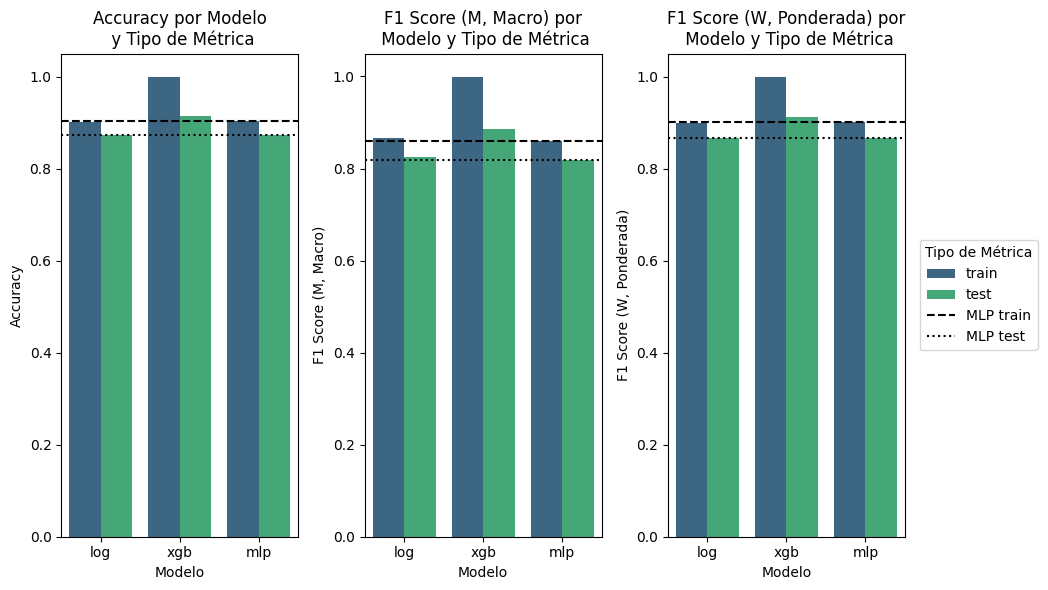

In [ ]:
# Figura y ejes
fig, axes = plt.subplots(1, 3, figsize = (10, 6))

# Gráfico para 'accuracy'
sns.barplot(
    data = df_metrics_fin,
    x = 'model',
    y = 'accuracy',
    hue = 'metric_type',
    palette = 'viridis',
    ax = axes[0]
)
axes[0].set_title('Accuracy por Modelo\n y Tipo de Métrica')
axes[0].set_xlabel('Modelo')
axes[0].set_ylabel('Accuracy')
axes[0].legend_.remove()
# Líneas
axes[0].axhline(
    y = df_metrics_fin['accuracy'].iloc[4], # mlp train
    color = 'black',
    linestyle = '--',
    label = 'MLP train'
)
axes[0].axhline(
    y = df_metrics_fin['accuracy'].iloc[5], # mlp test
    color = 'black',
    linestyle = ':',
    label = 'MLP test'
)

# Gráfico para 'f1-score_m_avg'
sns.barplot(
    data = df_metrics_fin,
    x = 'model',
    y = 'f1-score_m_avg',
    hue = 'metric_type',
    palette = 'viridis',
    ax = axes[1]
)
axes[1].set_title('F1 Score (M, Macro) por\n Modelo y Tipo de Métrica')
axes[1].set_xlabel('Modelo')
axes[1].set_ylabel('F1 Score (M, Macro)')
axes[1].legend_.remove()
# Líneas
axes[1].axhline(
    y = df_metrics_fin['f1-score_m_avg'].iloc[4], # mlp train
    color = 'black',
    linestyle = '--'
)
axes[1].axhline(
    y = df_metrics_fin['f1-score_m_avg'].iloc[5], # mlp test
    color = 'black',
    linestyle = ':'
)

# Gráfico para 'f1-score_w_avg'
sns.barplot(
    data = df_metrics_fin,
    x = 'model',
    y = 'f1-score_w_avg',
    hue = 'metric_type',
    palette = 'viridis',
    ax=axes[2]
)
axes[2].set_title('F1 Score (W, Ponderada) por\n Modelo y Tipo de Métrica')
axes[2].set_xlabel('Modelo')
axes[2].set_ylabel('F1 Score (W, Ponderada)')
axes[2].legend_.remove()
# Líneas
axes[2].axhline(
    y = df_metrics_fin['f1-score_w_avg'].iloc[4], # mlp train
    color = 'black',
    linestyle = '--'
)
axes[2].axhline(
    y = df_metrics_fin['f1-score_w_avg'].iloc[5], # mlp `test
    color = 'black',
    linestyle = ':'
)

# Leyenda
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title = 'Tipo de Métrica',
    loc = 'center right',
    bbox_to_anchor = (1.05, 0.5)
)

# Ajustes finales
plt.tight_layout(rect = [0, 0, 0.925, 1])
plt.show()

Mediante el gráfico, se refuerzan las ideas:
- XGBoost presenta mayores valores siempre, pero más tendencia al sobreajuste.
- Regresión logística y MLP (la red neuronal) presentan valores muy parejos entre sí, y mucho menor tendencia al sobreajuste.

### Decisión

Si bien un alto rendimiento es muy importante, al tener en cuenta que se busca comparar textos que pudieran ser plagios basados en artículos de SpaceNews.com, resulta crucial que el modelo seleccionado generalice bien. Es decir, tenga un comportamiento similar frente a datos nuevos: en este caso, textos que no se utilizaron en el entrenamiento. De esto se deriva la eliminación del modelo XGBoost.

Dado que los dos modelos restantes son realmente muy similares, en este momento **se opta por el de regresión logística.** Comparado con la red neuronal (multi-layered perceptron), presenta una mayor explicabilidad, además de que el archivo binario resultante es más liviano (45 kb vs 133 kb).

Así, se espera con esto implementar un primer producto que permita a SpaceNews.com detectar plagios.

## Conclusiones

### NLP

- La eliminación de stopwords facilita la identificación de patrones relevantes, aunque podría perderse algo de información. En general, el preprocesamiento redujo la dimensión de los datos, volviéndolos más manejable y relevante para tareas de análisis de texto y modelado predictivo.
- La implementación de una 'bolsa de palabras' deja en evidencia que no siempre las palabras más frecuentes aportan más información. En menor medida sucede con los bigramas y los trigramas.
- Al momento de contabilizar frecuencias para la bolsa de palabras, el número puede verse variando al comparar los contenidos lematizados, vs los contenidos radicalizados, excepto para trigramas. Eso parecería sugerir que a mayores n-gramas, menor diferencia entre aplicar lematización o radicalización.
- La utilización de TF-IDF Vectorizer es ideal en la implementación del presente trabajo, ya que permite distinguir los estilos de cada autor, al computar la frecuencia de las palabras que utilizan, y la frecuencia inversa del documento.
- La lematización y la radicalización no parecen tener un impacto suficiente en los resultados del vectorizador TF-IDF, dado que los modelos de aprendizaje automático mostraron idénticas métricas en ambos casos.


### Redes Neuronales

- Inicialmente, se implementó una red convolucional de tres capas, para estar en línea con lo visto en clases y lo indicado en la consigna. Sin embargo, un *accuracy* muy bajo llevó a una investigación al respecto de cuáles redes eran las más adecuadas para el tipo de problema a resolver. Por esta razón, se optó por una del tipo MLP (multi-layered perceptron).
- Al implementar la red MLP, se comenzó con una arquitectura de tres capas (una de entrada, una oculta y una de salida), y luego se experimentó con arquitecturas más complejas, incluyendo hasta ocho capas ocultas, además de integrar técnicas como *dropout* y *batch normalization* para mejorar el rendimiento.
- Tras haber complejizado considerablemente la arquitectura, se percibió que era necesario volver a reducir su complejidad. Esto se debió a métricas de *accuracy* (entrenamiento y prueba) que indicaban sobreajuste.
- Finalmente se llegó a una red con dos capas ocultas, más una entrada y una de salida.
 - La primera capa oculta incluye ReLU (introducción de alinealidad), complementada con *batch normalization* y *dropout* (estabilizando y contra el sobreajuste).
 - La segunda capa oculta conecta las neuronas de la primera capa a las clases de salida, permitiendo al modelo hacer predicciones sobre la variable objetivo.
- Tras todo este trabajo, el uso de una red neuronal parece, en primera instancia, estar injustificado, ya que un modelo de aprendizaje automático más simple, como la regresión logística, obtuvo buenas métricas y mostró menor sobreajuste, sin necesidad de ajustes complejos de hiperparámetros.

## Líneas Futuras

- Debido a un enfoque muy conservador respecto de los recursos computacionales disponibles, se utilizó un número relativamente bajo de características para el vectorizador TF-IDF: 500, que no parecen ser demasiadas para el tipo de problema. Por ello, todos los modelos se entrenaron en cuestión de minutos o incluso segundos. Aquí hay espacio para mejora.

- Durante el desarrollo de este trabajo no se hizo un gran ajuste de hiperparámetros. Esto aplica tanto a los modelos de aprendizaje automático, como profundo. Es posible que al llevar a cabo este procedimiento resulte posible elevar el rendimiento del clasificador, evitando a la vez el sobreajuste.

- De la misma forma, al referirse a la red neuronal, es posible que todavía convenga simplificar un poco su arquitectura, apuntando a mejorar su capacidad de generalización. Un potencial cambio sería bajar la cantidad de neuronas a 32.
